In [42]:
#!pip install pmdarima

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support # Cái này sẽ dùng để đánh giá model


# Read data

In [44]:
b16 = pd.read_csv("bike-ped-auto-counts-2016.csv")
b17 = pd.read_csv("bike-ped-auto-counts-2017.csv")
b18 = pd.read_csv("bike-ped-auto-counts-2018.csv")
b19 = pd.read_csv("bike-ped-auto-counts-2019.csv")
b20 = pd.read_csv("bike-ped-auto-counts-2020.csv")

In [45]:
print(b16.shape)
print(b17.shape)
print(b18.shape)
print(b19.shape)
print(b20.shape)

(366, 90)
(365, 100)
(365, 97)
(365, 44)
(366, 55)


In [46]:
b16_in = b16["Bicentennial Bikeway Cyclists Inbound"]
b16_out = b16["Bicentennial Bikeway Cyclists Outbound"]
b16_all = b16_in + b16_out

In [47]:
b17_in = b17["Bicentennial Bikeway Cyclists Inbound"]
b17_out = b17["Bicentennial Bikeway Cyclists Outbound"]
b17_all = b17_in + b17_out

In [48]:
b18_in = b18["Bicentennial Bikeway Cyclists Inbound"]
b18_out = b18["Bicentennial Bikeway Cyclists Outbound"]
b18_all = b18_in + b18_out

In [49]:
b19_all = b19["A019 ,Bicentennial Bikeway, Milton ,Cyclists"]

In [50]:
b20_all = b20["A019, Bicentennial Bikeway, Milton Cyclist"]

In [51]:
print(b16_all.shape)
print(b17_all.shape)
print(b18_all.shape)
print(b19_all.shape)
print(b20_all.shape)

(366,)
(365,)
(365,)
(365,)
(366,)


In [52]:
date_range_2016 = pd.date_range(start='2016-01-01', end='2016-12-31')
date_range_2017 = pd.date_range(start='2017-01-01', end='2017-12-31')
date_range_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')
date_range_2019 = pd.date_range(start='2019-01-01', end='2019-12-31')
date_range_2020 = pd.date_range(start='2020-01-01', end='2020-12-31')

# Concatenate the data into a single time series
time_series = np.concatenate([b16_all, b17_all, b18_all, b19_all, b20_all])

# Create a date index for the concatenated time series
date_index = pd.date_range(start='2016-01-01', end='2020-12-31')

# Create a DataFrame to store the time series data with the date index
time_series_df = pd.DataFrame({'Value': time_series}, index=date_index)

# Print the shape and the first few rows of the concatenated time series
print(time_series_df.shape)
print(time_series_df.head())

(1827, 1)
             Value
2016-01-01  1785.0
2016-01-02  2556.0
2016-01-03  2059.0
2016-01-04  2052.0
2016-01-05   626.0


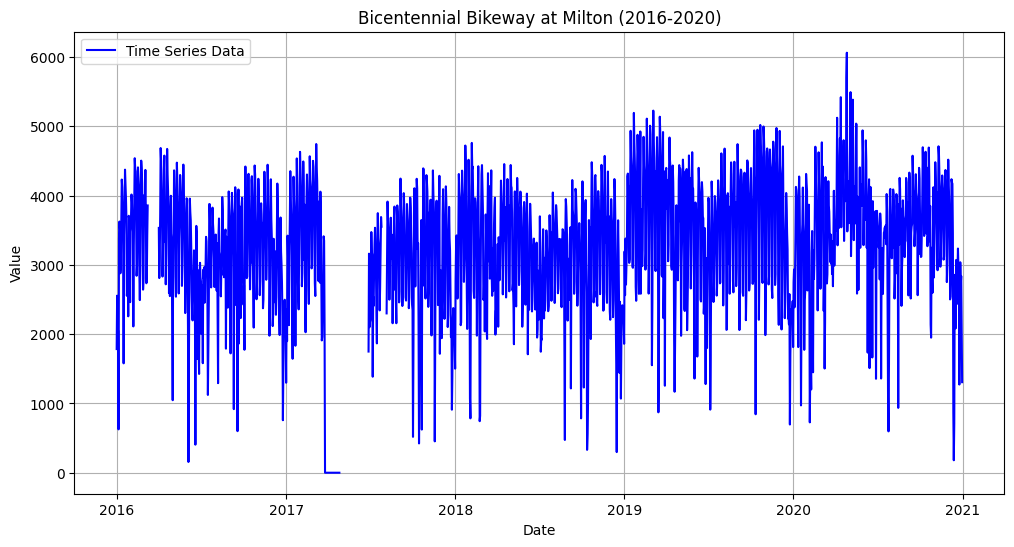

In [53]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.index, time_series_df['Value'], label='Time Series Data', color='blue')
plt.title('Bicentennial Bikeway at Milton (2016-2020)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Our dataset exhibits gaps in the records for the year 2017 (and some in 2016), likely caused by the temporary closure of the bike path, resulting in an interruption in the count of cyclists at the Bicentennial Bikeway in Milton. This interruption is due to the non-linear nature of the time series data for Bicentennial Bikeway Cyclists in Milton.

Here, I consider the Pedestrians data as side data. We can do analysis on this to determine how it affects to our original data.

In [54]:
Pedestrians_time_series = np.concatenate([b16["Bicentennial Bikeway Pedestrians Inbound"] + b16["Bicentennial Bikeway Pedestrians Outbound"], 
                                          b17["Bicentennial Bikeway Pedestrians Inbound"] + b17["Bicentennial Bikeway Pedestrians Outbound"], 
                                          b18["Bicentennial Bikeway Pedestrians Inbound"] + b18["Bicentennial Bikeway Pedestrians Outbound"], 
                                          b19["A019 ,Bicentennial Bikeway, Milton ,Pedestrians"], 
                                          b20["A019, Bicentennial Bikeway, Milton Pedestrian"]])


# Create a date index for the concatenated time series
date_index = pd.date_range(start='2016-01-01', end='2020-12-31')

# Create a DataFrame to store the time series data with the date index
Pedestrians_df = pd.DataFrame({'Value': Pedestrians_time_series}, index=date_index)

# Print the shape and the first few rows of the concatenated time series
print(Pedestrians_df.shape)
print(Pedestrians_df.head())

(1827, 1)
             Value
2016-01-01  1107.0
2016-01-02  1108.0
2016-01-03  1101.0
2016-01-04   762.0
2016-01-05   365.0


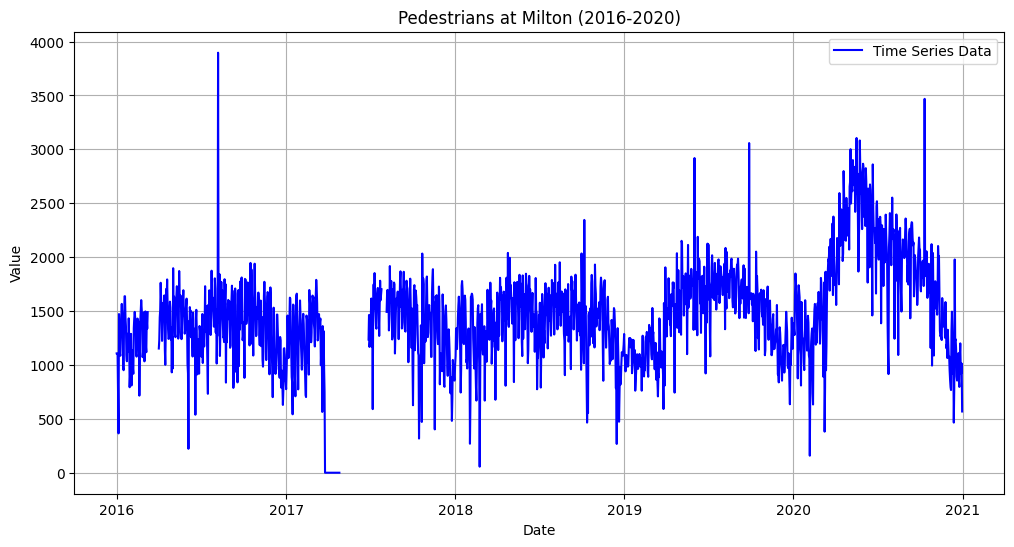

In [55]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(Pedestrians_df.index, Pedestrians_df['Value'], label='Time Series Data', color='blue')
plt.title('Pedestrians at Milton (2016-2020)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Well, the Pedestrians road also was closed in 2017 and a short period in 2016.

In [56]:
combine_data = pd.DataFrame({'Cyclists': time_series_df['Value'], 'Pedestrians': Pedestrians_df['Value']})

correlation_matrix = combine_data.corr()
correlation_matrix.style.background_gradient(cmap='YlOrRd')

The correlation is not too high, however, we can consider that if the number of pandestrians increase, the number of cyclists also increase. Moreover, I think if we want to use this Pedestrians data to predict cyclists, we have to scale the range of values and do similar method to preprocess both data.

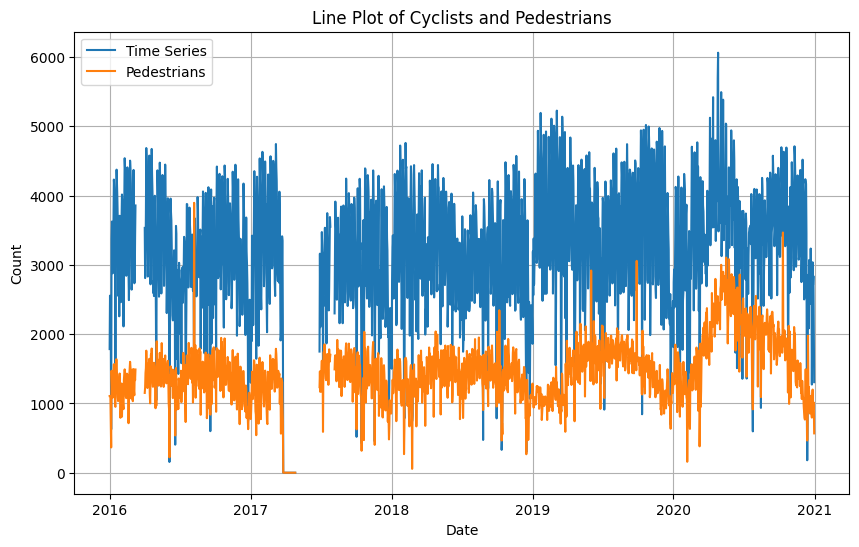

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(combine_data['Cyclists'], label='Time Series')
plt.plot(combine_data['Pedestrians'], label='Pedestrians')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Line Plot of Cyclists and Pedestrians')
plt.legend()
plt.grid(True)
plt.show()

# Preparation

In [58]:
time_series_df.head()

Value
2016-01-01  1785.0
2016-01-02  2556.0
2016-01-03  2059.0
2016-01-04  2052.0
2016-01-05   626.0

In [59]:
# there're 95 null values
time_series_df['Value'].isna().sum()

95

In [60]:
# 23 null values in 2016
b16_all.isna().sum()

23

In [61]:
# 72 null values in 2017
b17_all.isna().sum()

72

Filling null and 0s values. Here I calculate the mean of previous year and next year value to replace the null value of current year. If previous year value or next year value is also null, I'll replace by median value of the whole dataset (we can see a straight line in 2016)

In [62]:
median_value = time_series_df['Value'].median()
filled_df = time_series_df.copy()

for idx, row in time_series_df.iterrows():
    if pd.notna(row['Value']) and row['Value'] > 0:
        continue  
    
    prev_year = idx - pd.DateOffset(years=1)
    next_year = idx + pd.DateOffset(years=1)
    
    prev_year_value = time_series_df.at[prev_year, 'Value'] if prev_year in time_series_df.index else None
    next_year_value = time_series_df.at[next_year, 'Value'] if next_year in time_series_df.index else None
    
    if (prev_year_value is not None and next_year_value is not None):
        fill_value = (
            pd.Series([prev_year_value, next_year_value])
            .mean()
        )
    else: fill_value = median_value
    
    time_series_df.at[idx, 'Value'] = fill_value

In [63]:
median_value

3419.5

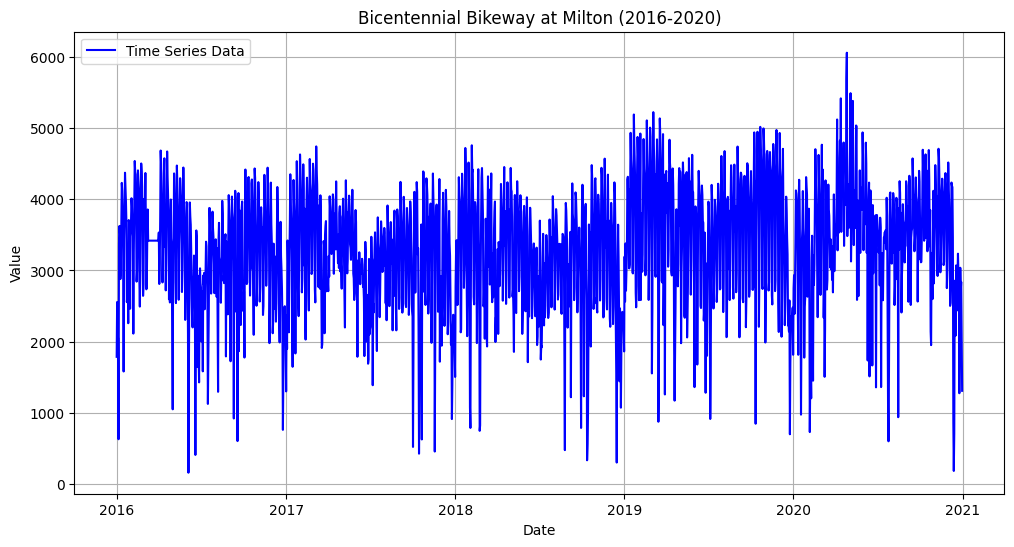

In [64]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.index, time_series_df['Value'], label='Time Series Data', color='blue')
plt.title('Bicentennial Bikeway at Milton (2016-2020)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
print(time_series_df['Value'].isna().sum())

0


Well, actually I could apply ML techniques to predict missing values, however, I wouldn't do that because of overcomplexity. I just did a simple method as I said above

# EDA

In [66]:
time_series_df.describe()

Value
count  1827.000000
mean   3307.687466
std     855.690001
min     155.000000
25%    2749.500000
50%    3419.500000
75%    3920.000000
max    6063.000000

- Mean is 3080.545
- Std is 1193.682

<Axes: >

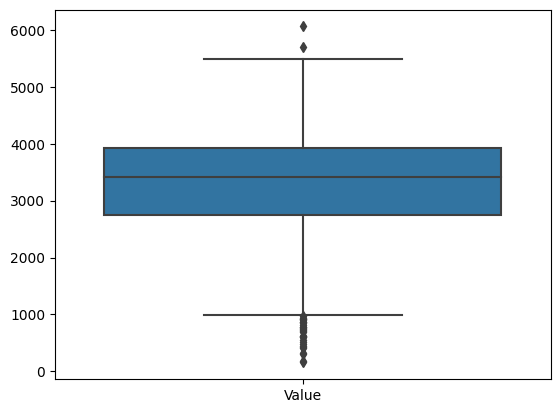

In [67]:
sns.boxplot(time_series_df)

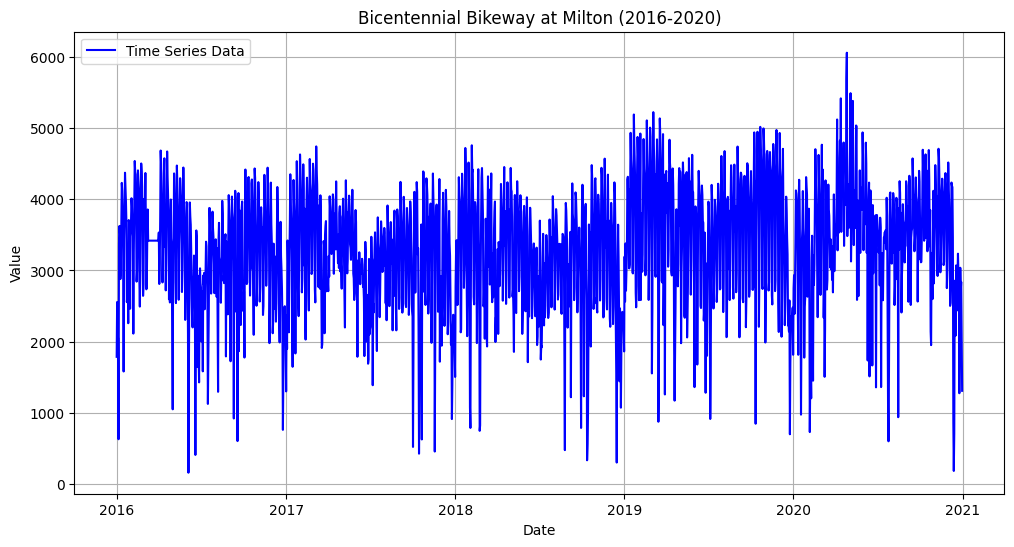

In [68]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.index, time_series_df['Value'], label='Time Series Data', color='blue')
plt.title('Bicentennial Bikeway at Milton (2016-2020)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
time_series_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=1827, freq='D')

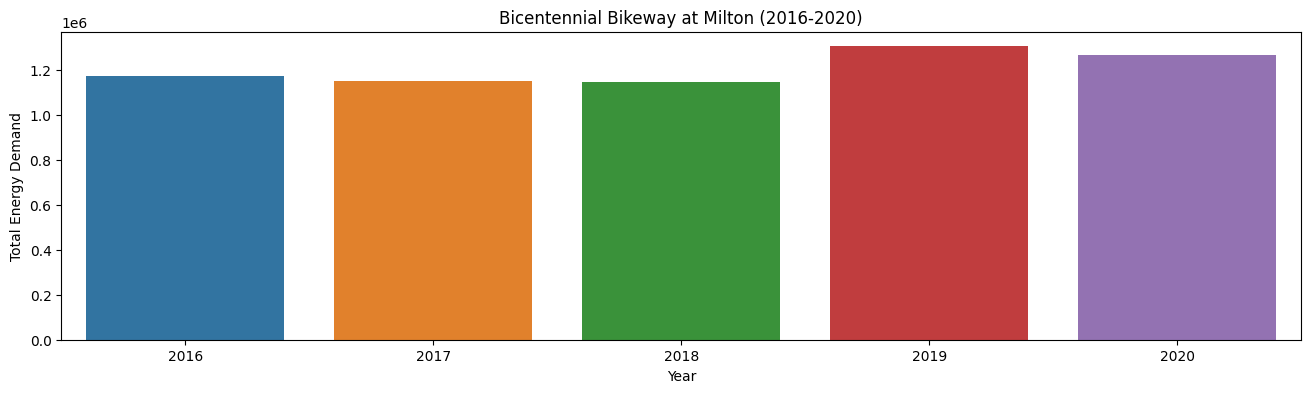

In [70]:
yearly_data = time_series_df['Value'].groupby(time_series_df.index.year).sum()

fig, axes = plt.subplots(1, 1, squeeze=False)
fig.set_size_inches(16, 4)
sns.barplot(x=yearly_data.index, y=yearly_data, ax=axes[0, 0])
axes[0, 0].set_title("Bicentennial Bikeway at Milton (2016-2020)")
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Total Energy Demand')

plt.show()

2019 has the highest number of cyclists

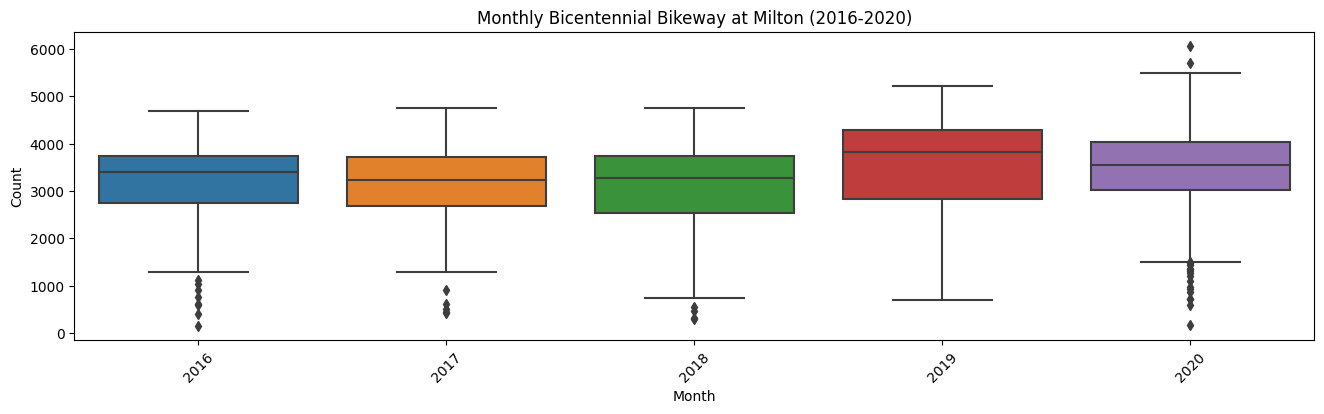

In [71]:
plt.figure(figsize=(16, 4))
sns.boxplot(x=time_series_df.index.strftime('%Y'), y=time_series_df['Value'])
plt.title("Monthly Bicentennial Bikeway at Milton (2016-2020)")
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Most years have outliers except 2019

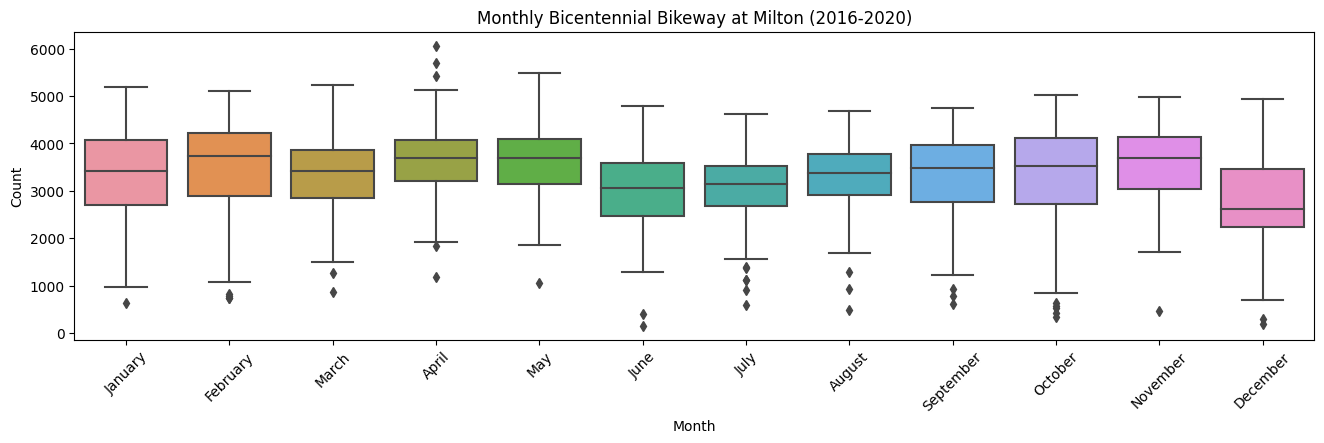

In [72]:
plt.figure(figsize=(16, 4))
sns.boxplot(x=time_series_df.index.strftime('%B'), y=time_series_df['Value'])
plt.title("Monthly Bicentennial Bikeway at Milton (2016-2020)")
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'Bicentennial Bikeway Cyclists at Milton')

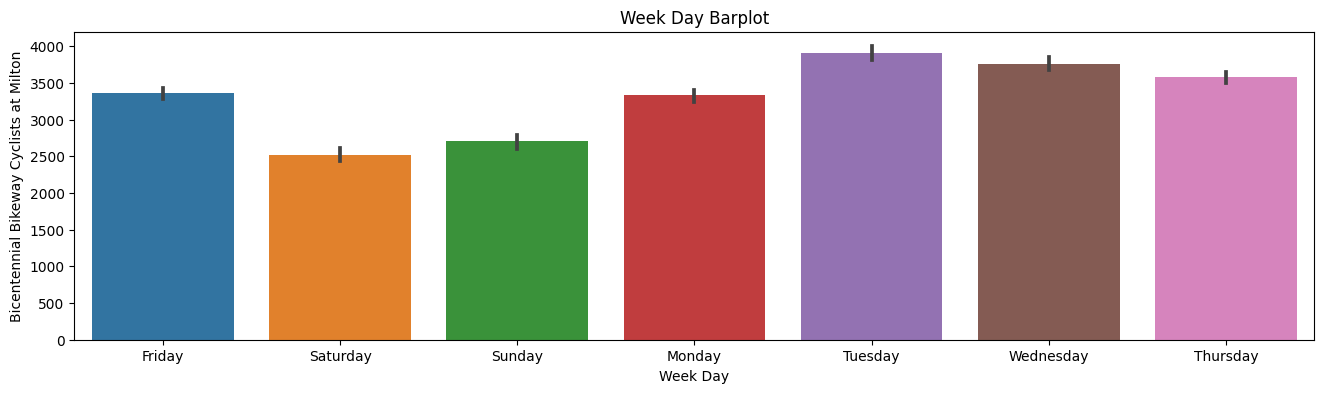

In [73]:
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.barplot(data=time_series_df, x=time_series_df.index.day_name(), y=time_series_df['Value'], ax=axes[0,0])
axes[0,0].set_title("Week Day Barplot")
axes[0,0].set_xlabel('Week Day')
axes[0,0].set_ylabel('Bicentennial Bikeway Cyclists at Milton')

We can see that, The highest number of cyclists is on Tuesdays.

# Task 3

In [74]:
test_end_date = time_series_df.index.max()

# Calculate the start date of the test set by subtracting 3 months
test_start_date = test_end_date - pd.DateOffset(months=3)

# Split the data into train and test sets based on the date ranges
train_set = time_series_df[time_series_df.index < test_start_date]
test_set = time_series_df[(time_series_df.index >= test_start_date) & (time_series_df.index <= test_end_date)]

print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)


Train set shape: (1734, 1)
Test set shape: (93, 1)


In [75]:
test_set

Value
2020-09-30  4246.0
2020-10-01  3722.0
2020-10-02  3629.0
2020-10-03  3115.0
2020-10-04  3120.0
...            ...
2020-12-27  3038.0
2020-12-28  2711.0
2020-12-29  2839.0
2020-12-30  2081.0
2020-12-31  1307.0

[93 rows x 1 columns]

## STR Mantually

### Step 1: Isolate the trend 

In [76]:
# rolling here means moving average (MA)
train_set_copy = train_set.copy()

# Calculate the rolling means
train_set_copy['MA3'] = train_set_copy['Value'].rolling(3).mean()
train_set_copy['MA7'] = train_set_copy['Value'].rolling(7).mean()
train_set_copy['MA15'] = train_set_copy['Value'].rolling(15).mean()

Rolling means we take 3 (7 or 15) days data to calculate the avarage (smoothing data)

In [77]:
train_set_copy

Value          MA3          MA7         MA15
2016-01-01  1785.0          NaN          NaN          NaN
2016-01-02  2556.0          NaN          NaN          NaN
2016-01-03  2059.0  2133.333333          NaN          NaN
2016-01-04  2052.0  2222.333333          NaN          NaN
2016-01-05   626.0  1579.000000          NaN          NaN
...            ...          ...          ...          ...
2020-09-25  3807.0  3944.666667  3768.857143  3767.333333
2020-09-26  2563.0  3451.000000  3667.857143  3770.533333
2020-09-27  3379.0  3249.666667  3662.571429  3764.666667
2020-09-28  3153.0  3031.666667  3605.428571  3738.000000
2020-09-29  4401.0  3644.333333  3618.571429  3791.933333

[1734 rows x 4 columns]

we can see that, as I said before, in MA7, we took 6 first months to calculate the avarage value, so that the first 6 rows are null values.

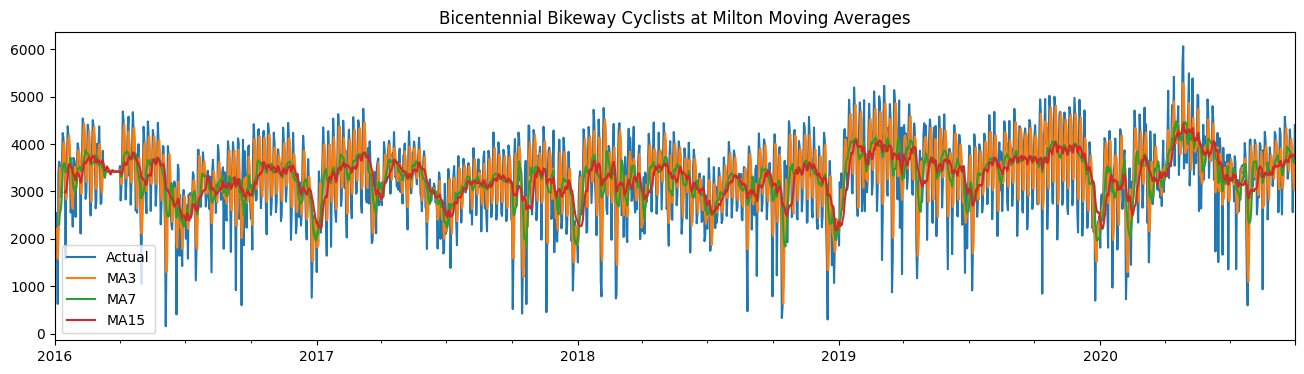

In [78]:
# Plot the data from the copy
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
train_set_copy['Value'].plot(ax=ax, label='Actual')
train_set_copy['MA3'].plot(ax=ax, label='MA3')
train_set_copy['MA7'].plot(ax=ax, label='MA7')
train_set_copy['MA15'].plot(ax=ax, label='MA15')
plt.title('Bicentennial Bikeway Cyclists at Milton Moving Averages')
plt.legend()
plt.show()

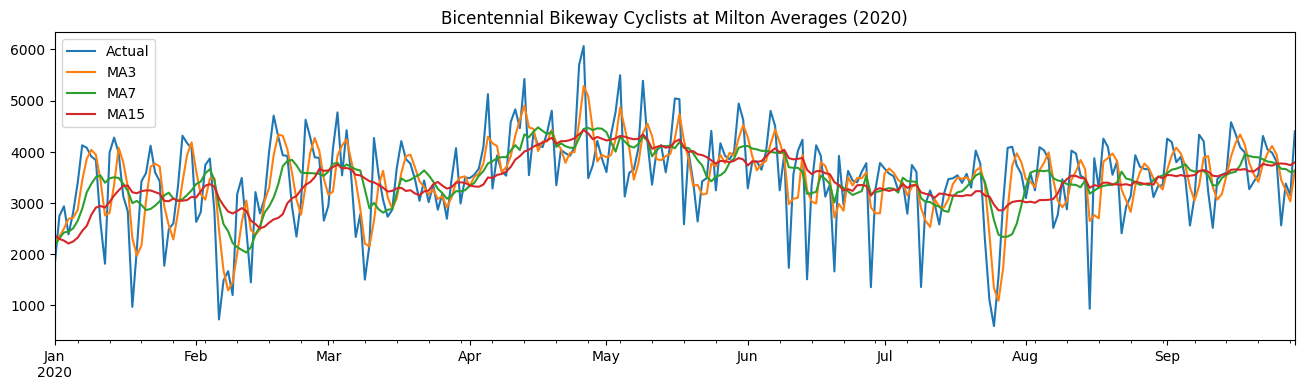

In [79]:
# Plot the data from the copy
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
train_set_copy['2020':]['Value'].plot(ax=ax, label='Actual')
train_set_copy['2020':]['MA3'].plot(ax=ax, label='MA3')
train_set_copy['2020':]['MA7'].plot(ax=ax, label='MA7')
train_set_copy['2020':]['MA15'].plot(ax=ax, label='MA15')
plt.title('Bicentennial Bikeway Cyclists at Milton Averages (2020)')
plt.legend()
plt.show()

Here, we can see that while MA3 looks like the original data, MA15 is likely oversmoothing. Therefore, I choose MA7 with 7 is a week seasonally.

### Step 2: De-trend the series

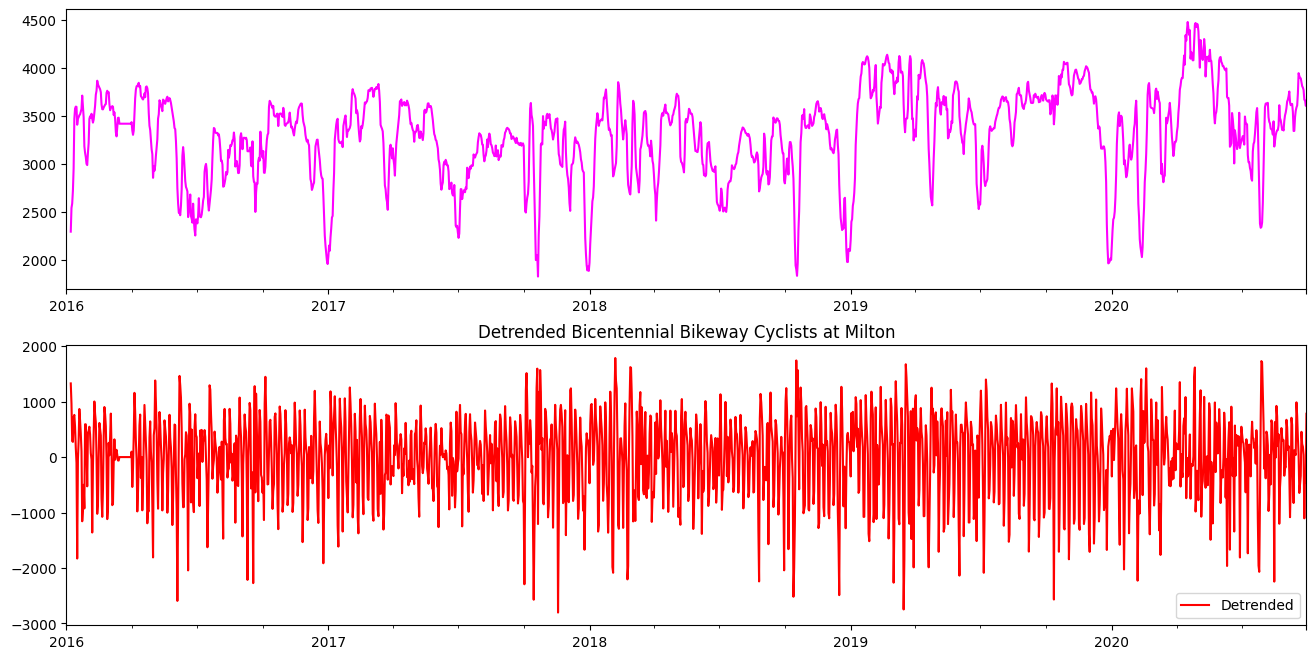

In [80]:
# Calculate the detrended data
train_set_copy['detrended'] = train_set_copy['Value'] - train_set_copy['MA7']

fig, ax_detrended = plt.subplots(2)
fig.set_size_inches(16, 8)
train_set_copy['MA7'].plot(color='magenta', ax=ax_detrended[0], label='MA7')
train_set_copy['detrended'].plot(color='red', ax=ax_detrended[1], label='Detrended')
plt.legend()
plt.title('Detrended Bicentennial Bikeway Cyclists at Milton')
plt.show()


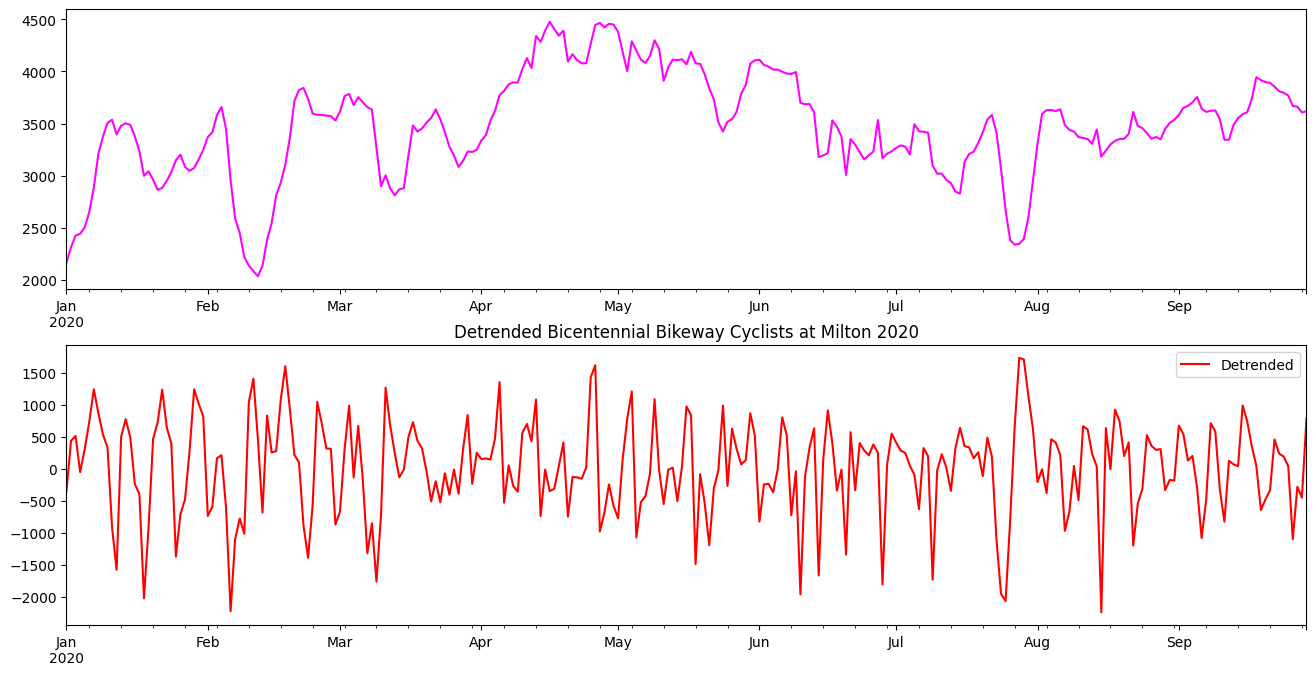

In [81]:
# Plot the detrended data 2020
fig, ax_detrended = plt.subplots(2)
fig.set_size_inches(16, 8)
train_set_copy['2020':]['MA7'].plot(color='magenta', ax=ax_detrended[0], label='MA7')
train_set_copy['2020':]['detrended'].plot(color='red',ax=ax_detrended[1], label='Detrended')
plt.title('Detrended Bicentennial Bikeway Cyclists at Milton 2020')
plt.legend()
plt.show()

### 1.3 Estimate the seasonal component

In [82]:
raw_day_means = train_set_copy.groupby(train_set_copy.index.day)['detrended'].mean()
num_days = len(raw_day_means)
adjustment = raw_day_means.sum() / num_days  # Adjust to sum to zero
day_means = raw_day_means - adjustment  # Constrain the values

# Calculate the number of repetitions
n_repeats = len(train_set_copy) // num_days

# Extend month_means to fill the required number of values
day_list = (day_means.tolist() * n_repeats) + day_means.tolist()[:len(train_set_copy) % num_days]

train_set_copy['Seasonal'] = day_list

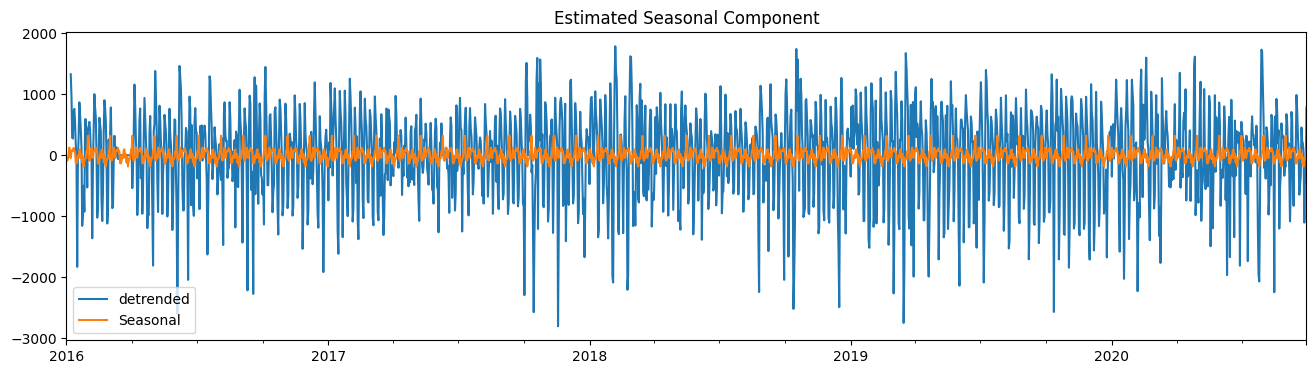

In [83]:
fig, ax_seasonal = plt.subplots()
fig.set_size_inches(16, 4)
train_set_copy['detrended'].plot(label='detrended', ax=ax_seasonal)
train_set_copy['Seasonal'].plot(label='Seasonal', ax=ax_seasonal)
plt.title('Estimated Seasonal Component')
plt.legend()
plt.show()

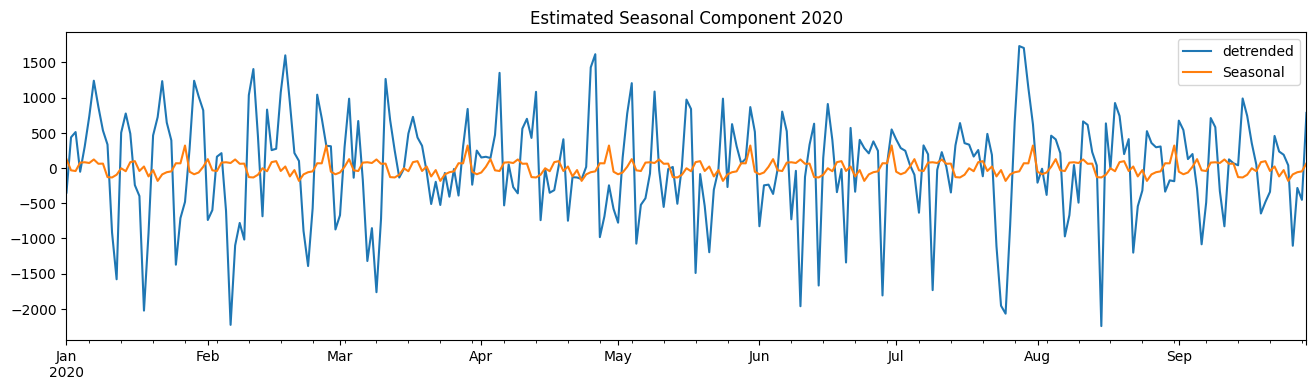

In [84]:
fig, ax_seasonal = plt.subplots()
fig.set_size_inches(16, 4)
train_set_copy['2020':]['detrended'].plot(label='detrended', ax=ax_seasonal)
train_set_copy['2020':]['Seasonal'].plot(label='Seasonal', ax=ax_seasonal)
plt.title('Estimated Seasonal Component 2020')
plt.legend()
plt.show()

We can see that the season are repeated every month (in 2020).

### Step 4: Calculate the residual

In [85]:
train_set_copy['Residual'] = train_set_copy['Value'] - train_set_copy['MA7'] - train_set_copy['Seasonal']

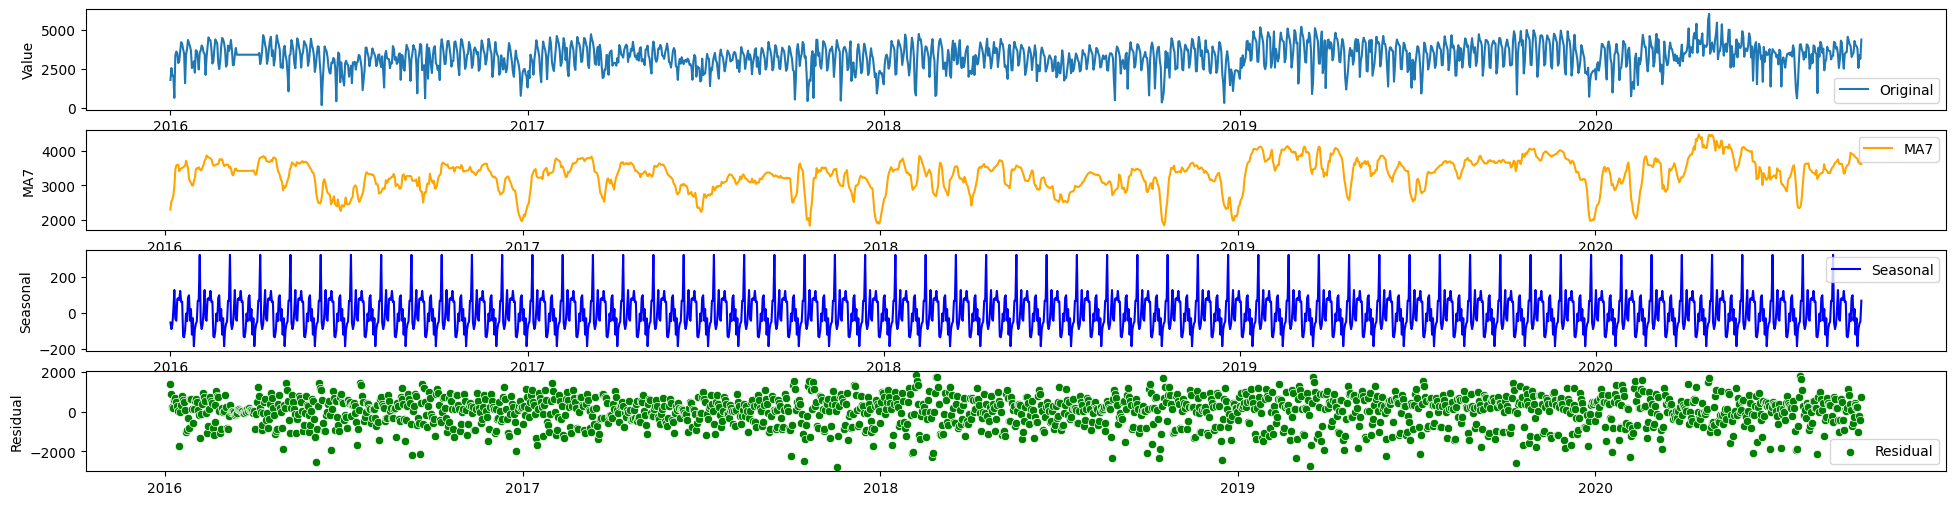

In [86]:
fig, ax_str = plt.subplots(4, figsize=(24, 6))
sns.lineplot(data=train_set_copy['Value'], label='Original', ax=ax_str[0])
sns.lineplot(data=train_set_copy['MA7'], color='orange', label='MA7', ax=ax_str[1])
sns.lineplot(data=train_set_copy['Seasonal'], color='blue', label='Seasonal', ax=ax_str[2])
sns.scatterplot(data=train_set_copy, x=train_set_copy.index, y='Residual', color='green', label='Residual', ax=ax_str[3])
plt.legend()
plt.show()

Compare the output with seasonal_decompose

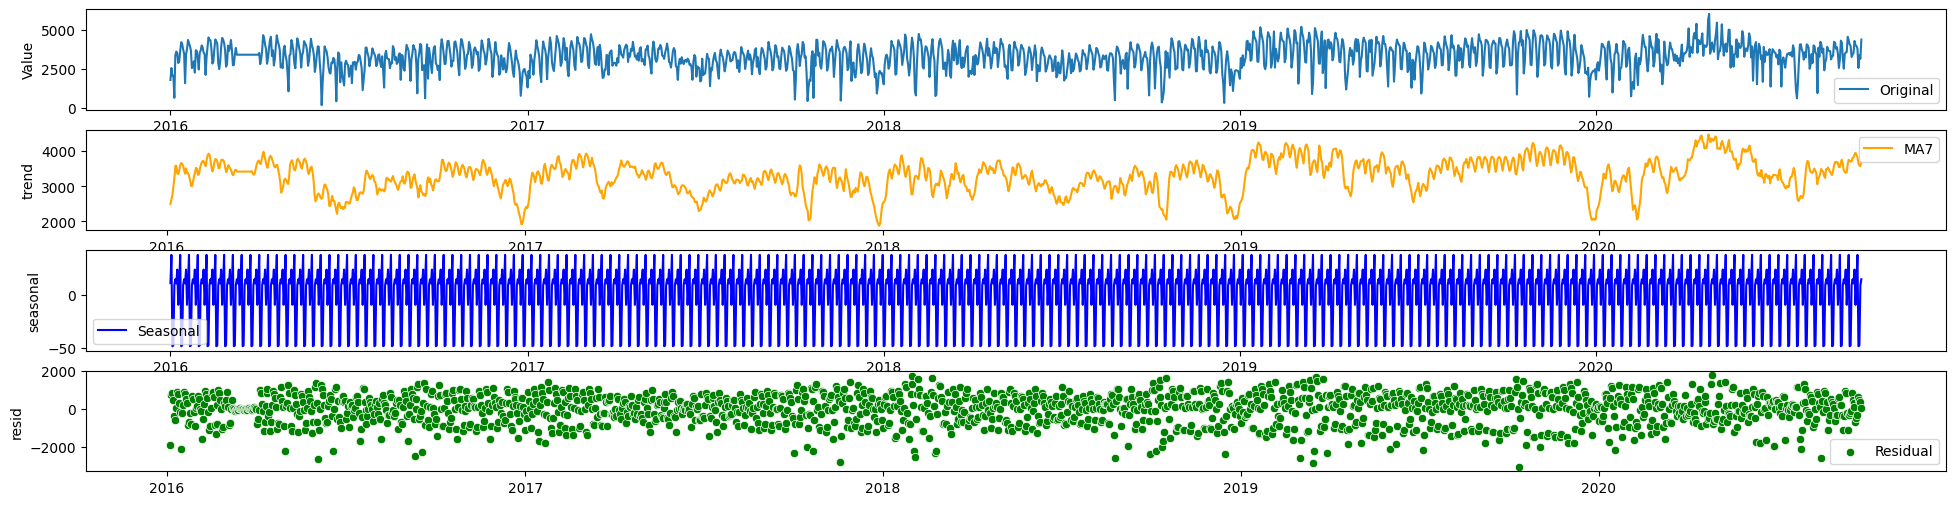

In [87]:
decompose_results = seasonal_decompose(train_set_copy['Value'], period=9)  # 9 days

fig, ax_str = plt.subplots(4, figsize=(24, 6))
sns.lineplot(data=train_set_copy['Value'], label='Original', ax=ax_str[0])
sns.lineplot(data=decompose_results.trend, color='orange', label='MA7', ax=ax_str[1])
sns.lineplot(data=decompose_results.seasonal, color='blue', label='Seasonal', ax=ax_str[2])
sns.scatterplot(data=decompose_results, x=train_set_copy.index, y=decompose_results.resid, color='green', label='Residual', ax=ax_str[3])
plt.legend()
plt.show()

Well, I did it correctly.

# Fit ARIMA model

## 4.1 Check for stationarity

To fig an autoregressive model or an ARIMA model that contains an AR component, the data must be stationary. The criteria for stationarity is that the data is:
- roughly horizontal
- constant variance
- no patterns predictable in the long-term

<Axes: >

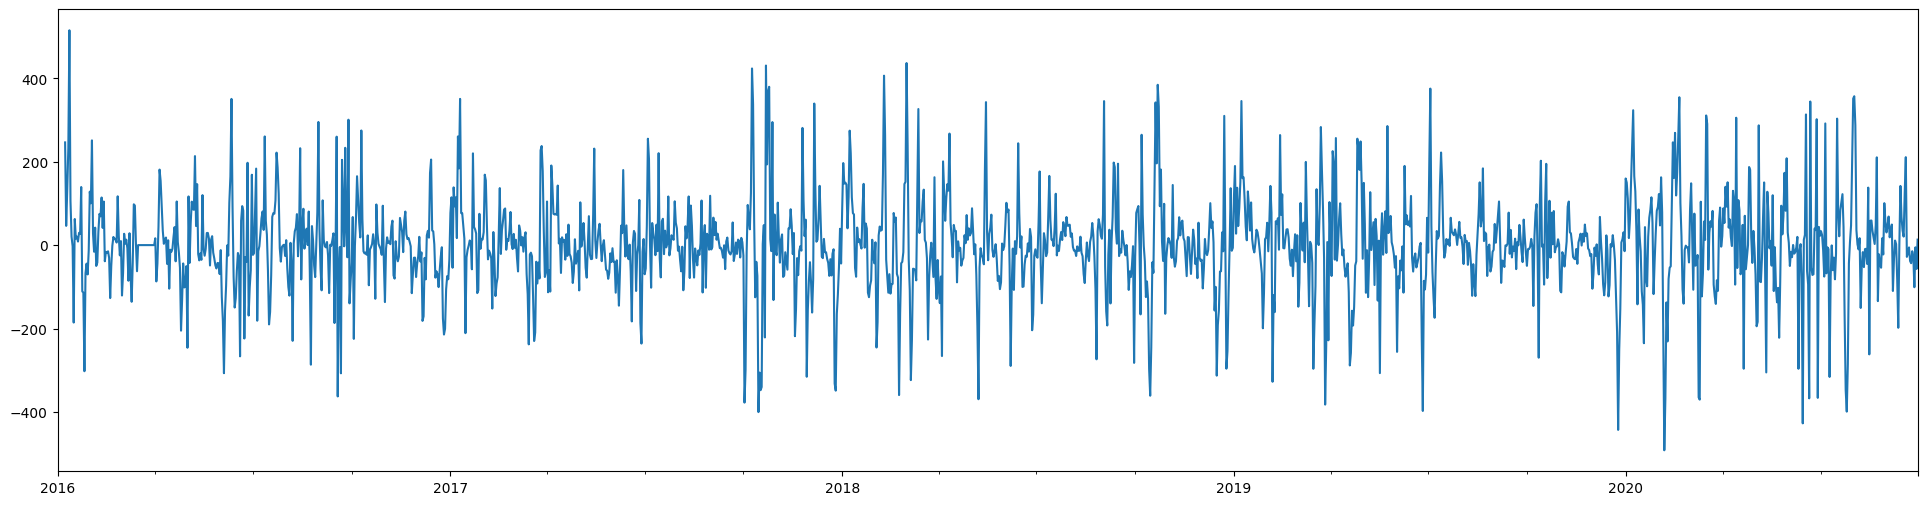

In [88]:
#trend_d1 = decompose_results.trend.diff()
trend_d1 = train_set_copy['MA7'].diff()
trend_d1.plot(figsize=(24,6))

This still contains lots of sub-series where the mean value moves up and down, and the variance (variability) is not constant throughout, so difference it again.

<Axes: >

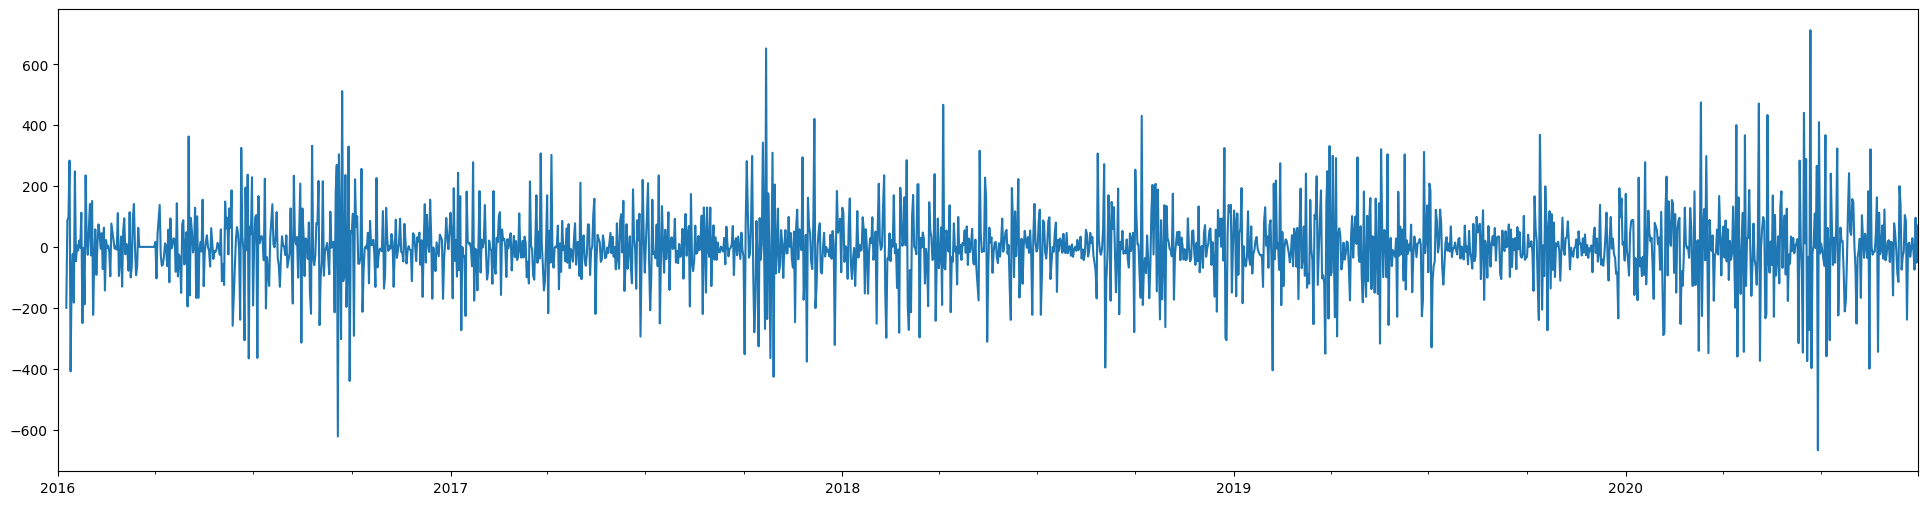

In [89]:
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6))

This trend is not perfect, but it is good enough for us to apply an ARIMA model to. (using d = 2)

Check if there is any evidence of autocorrelation in the data using the ACF and PCF plots (autocorrelation and partial autocorrelation).

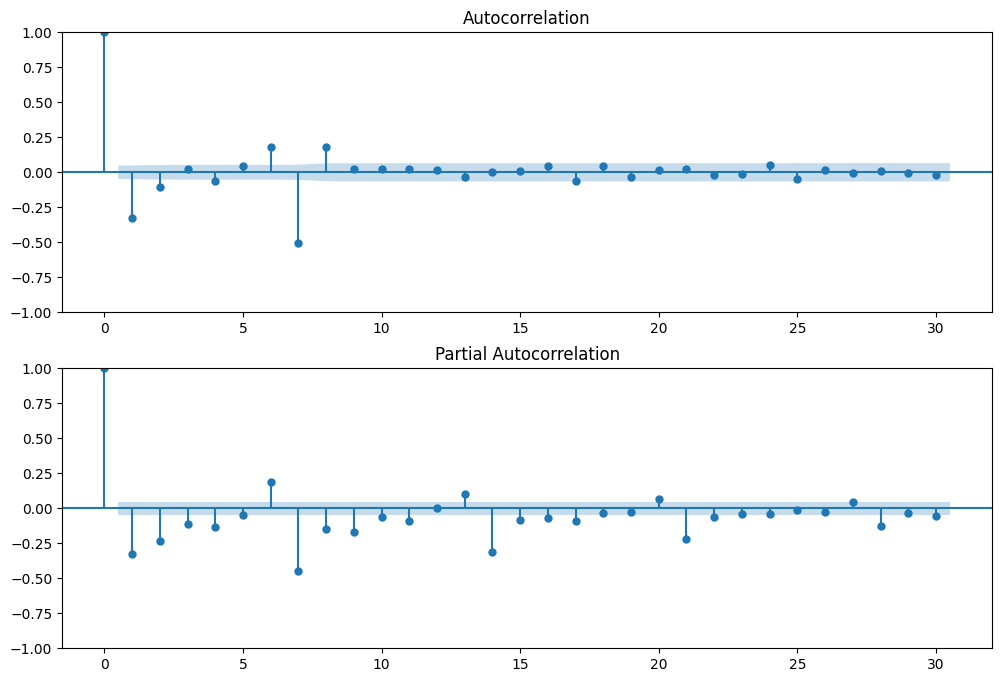

In [90]:
trend_d2_plot = trend_d2[31:]
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d2_plot, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d2_plot, lags=30, ax=ax2)

In [91]:
trend_d1

2016-01-01           NaN
2016-01-02           NaN
2016-01-03           NaN
2016-01-04           NaN
2016-01-05           NaN
                 ...    
2020-09-25    -26.285714
2020-09-26   -101.000000
2020-09-27     -5.285714
2020-09-28    -57.142857
2020-09-29     13.142857
Freq: D, Name: MA7, Length: 1734, dtype: float64

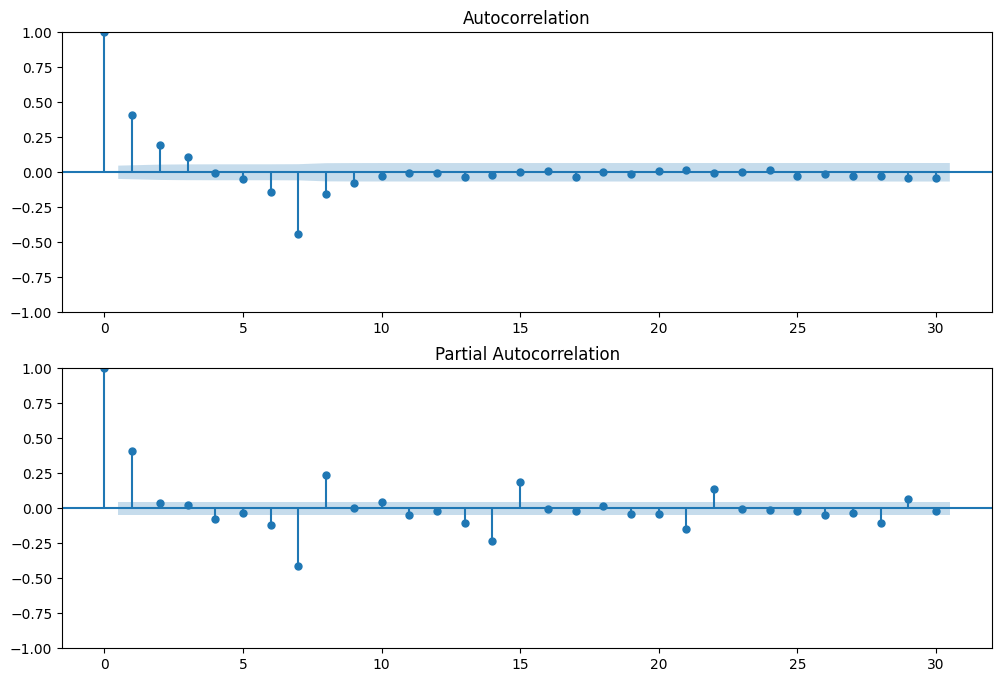

In [92]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1[31:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1[31:], lags=30, ax=ax2)

Now that the data has been made stationary, it can be modelled with an ARMA process. However, when using the software, it is better to use the full ARIMA model and set d=2 as determined above.

In [93]:
train_set_copy

Value          MA3          MA7         MA15    detrended  \
2016-01-01  1785.0          NaN          NaN          NaN          NaN   
2016-01-02  2556.0          NaN          NaN          NaN          NaN   
2016-01-03  2059.0  2133.333333          NaN          NaN          NaN   
2016-01-04  2052.0  2222.333333          NaN          NaN          NaN   
2016-01-05   626.0  1579.000000          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
2020-09-25  3807.0  3944.666667  3768.857143  3767.333333    38.142857   
2020-09-26  2563.0  3451.000000  3667.857143  3770.533333 -1104.857143   
2020-09-27  3379.0  3249.666667  3662.571429  3764.666667  -283.571429   
2020-09-28  3153.0  3031.666667  3605.428571  3738.000000  -452.428571   
2020-09-29  4401.0  3644.333333  3618.571429  3791.933333   782.428571   

              Seasonal     Residual  
2016-01-01  -53.076422          NaN  
2016-01-02  -89.361498          NaN  
2016-01-03  -63.668258          NaN  
2016-01-04   16.984165          NaN  
2016-01-05  125.588119          NaN  
...                ...          ...  
2020-09-25 -183.482593   221.625450  
2020-09-26  -90.975074 -1013.882068  
2020-09-27  -60.009536  -223.561893  
2020-09-28  -48.062794  -404.365778  
2020-09-29   67.226158   715.202414  

[1734 rows x 7 columns]

### Choosing and fitting to a ARIMA model

In [94]:
best_pdq = []

p_range = range(1, 9)
d_range = range(2, 3)  
q_range = range(1, 9)

for q in q_range:
    for d in d_range:
        for p in p_range:
            try:
                model = ARIMA(train_set_copy['MA7'], order=(p, d, q)).fit()
                best_pdq.append([p, d, q, model.aic, model.bic])
            except:
                pass

print(best_pdq)

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  w

[[1, 2, 1, 21004.26619809492, 21020.63729436229], [2, 2, 1, 21003.245685086345, 21025.073813442836], [3, 2, 1, 21004.549130276173, 21031.834290721785], [4, 2, 1, 20998.186458573917, 21030.92865110865], [5, 2, 1, 20998.512275334528, 21036.711499958383], [6, 2, 1, 21053.409651170612, 21097.065907883592], [7, 2, 1, 20732.572495976405, 20781.685784778507], [8, 2, 1, 20568.581352245164, 20623.151673136388], [1, 2, 2, 21003.1167809406, 21024.94490929709], [2, 2, 2, 20985.29780877167, 21012.58296921728], [3, 2, 2, 20987.322690030574, 21020.064882565308], [4, 2, 2, 20981.11167284441, 21019.310897468265], [5, 2, 2, 20941.773791068277, 20985.430047781258], [6, 2, 2, 20925.947238704022, 20975.060527506124], [7, 2, 2, 20582.79775059457, 20637.368071485795], [8, 2, 2, 20570.472225818827, 20630.499578799172], [1, 2, 3, 20998.429883470504, 21025.715043916116], [2, 2, 3, 21321.28120308039, 21354.023395615124], [3, 2, 3, 20750.918088851882, 20789.117313475737], [4, 2, 3, 20800.788227851983, 20844.44448

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [95]:
pdq_df = pd.DataFrame(best_pdq, columns=['p', 'd', 'q', 'aic', 'bic'])

# Find the row with the minimum AIC
min_aic_row = pdq_df.loc[pdq_df['aic'].idxmin()]

# Extract the p, d, and q values with the minimum AIC
best_p = int(min_aic_row['p'])
best_d = int(min_aic_row['d'])
best_q = int(min_aic_row['q'])

print("DataFrame with AIC and BIC:")
print(pdq_df)
print(f"Best model selected based on AIC: (p={best_p}, d={best_d}, q={best_q}) with AIC = {int(min_aic_row['aic'])}")

DataFrame with AIC and BIC:
    p  d  q           aic           bic
0   1  2  1  21004.266198  21020.637294
1   2  2  1  21003.245685  21025.073813
2   3  2  1  21004.549130  21031.834291
3   4  2  1  20998.186459  21030.928651
4   5  2  1  20998.512275  21036.711500
.. .. .. ..           ...           ...
59  4  2  8  20194.390163  20265.331580
60  5  2  8  20197.860945  20274.259394
61  6  2  8  20199.780693  20281.636175
62  7  2  8  20200.590645  20287.903158
63  8  2  8  20200.909468  20293.679014

[64 rows x 5 columns]
Best model selected based on AIC: (p=1, d=2, q=8) with AIC = 20183


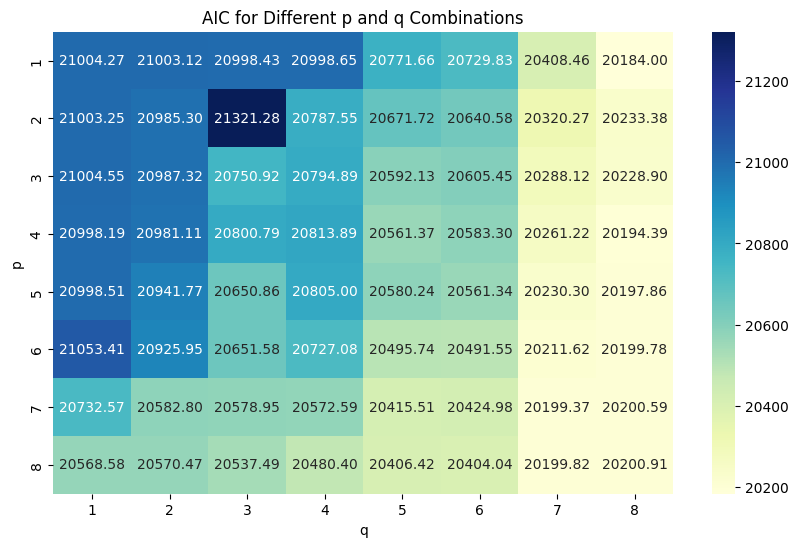

In [96]:
pivot_table = pd.pivot_table(pdq_df, values='aic', index='p', columns='q')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")

plt.xlabel('q')
plt.ylabel('p')
plt.title('AIC for Different p and q Combinations')

plt.show()

As both p and q increase, the AIC decreases, indicating greater model flexibility and improved data fitting. However, it's important to note that higher p and q values can also raise the model's variance, potentially resulting in overfitting.

In [97]:
# from the output above, I choose the appropriate combination of p,d,q to fit the model
best_model = ARIMA(train_set_copy['MA7'], order=(1, 2, 8)).fit()

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    MA7   No. Observations:                 1734
Model:                 ARIMA(1, 2, 8)   Log Likelihood              -10081.998
Date:                Fri, 27 Oct 2023   AIC                          20183.995
Time:                        15:37:29   BIC                          20238.566
Sample:                    01-01-2016   HQIC                         20204.178
                         - 09-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3843      0.032     12.006      0.000       0.322       0.447
ma.L1         -0.8680      0.023    -37.771      0.000      -0.913      -0.823
ma.L2         -0.0511      0.013     -3.994      0.0

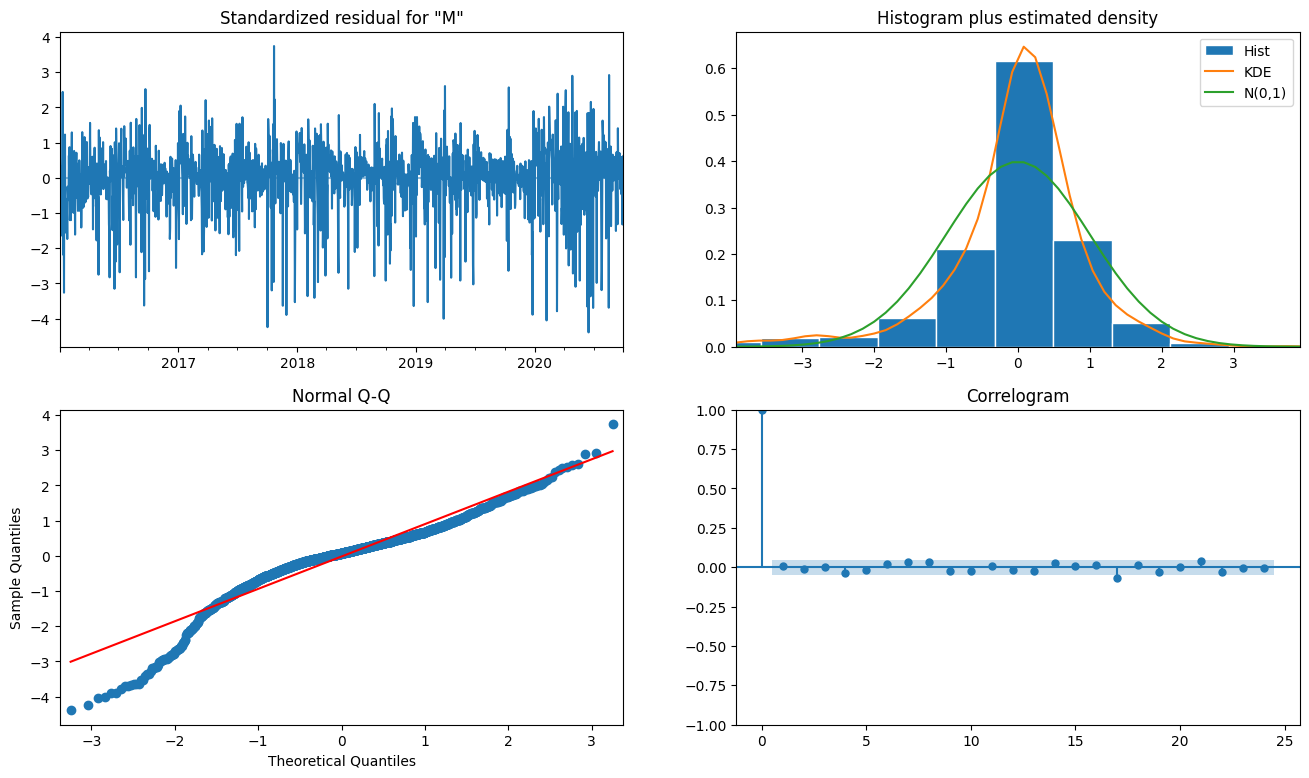

In [99]:
fig = plt.figure(figsize=(16, 9))
fig = best_model.plot_diagnostics(fig=fig, lags=24)

### Produce forecasts of Bicentennial Bikeway cyclist traffic at Milton for the test data series

In [100]:
# Keep the predictions orgainsied in a dedicated dataframe, beginning with the mean trend prediction:
arima_predictions = pd.DataFrame(index=test_set.index)
arima_predictions['Trend'] = best_model.predict(start=test_set.index[0], end=test_set.index[-1], typ='levels') 

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [101]:
arima_predictions['TrendSeasonal'] = ''
arima_predictions['Total'] = ''
for t in range(len(arima_predictions)):
    arima_predictions['TrendSeasonal'][t] = arima_predictions['Trend'][t] + train_set_copy['Seasonal'][t] 
    arima_predictions['Total'][t] = arima_predictions['Trend'][t] + train_set_copy['Seasonal'][t] + train_set_copy['Residual'][t]

C:\Users\ACER\AppData\Local\Temp\ipykernel_31620\3390827592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_predictions['TrendSeasonal'][t] = arima_predictions['Trend'][t] + train_set_copy['Seasonal'][t]
C:\Users\ACER\AppData\Local\Temp\ipykernel_31620\3390827592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_predictions['Total'][t] = arima_predictions['Trend'][t] + train_set_copy['Seasonal'][t] + train_set_copy['Residual'][t]
C:\Users\ACER\AppData\Local\Temp\ipykernel_31620\3390827592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [102]:
train_set_copy['Residual'].isna().sum()

6

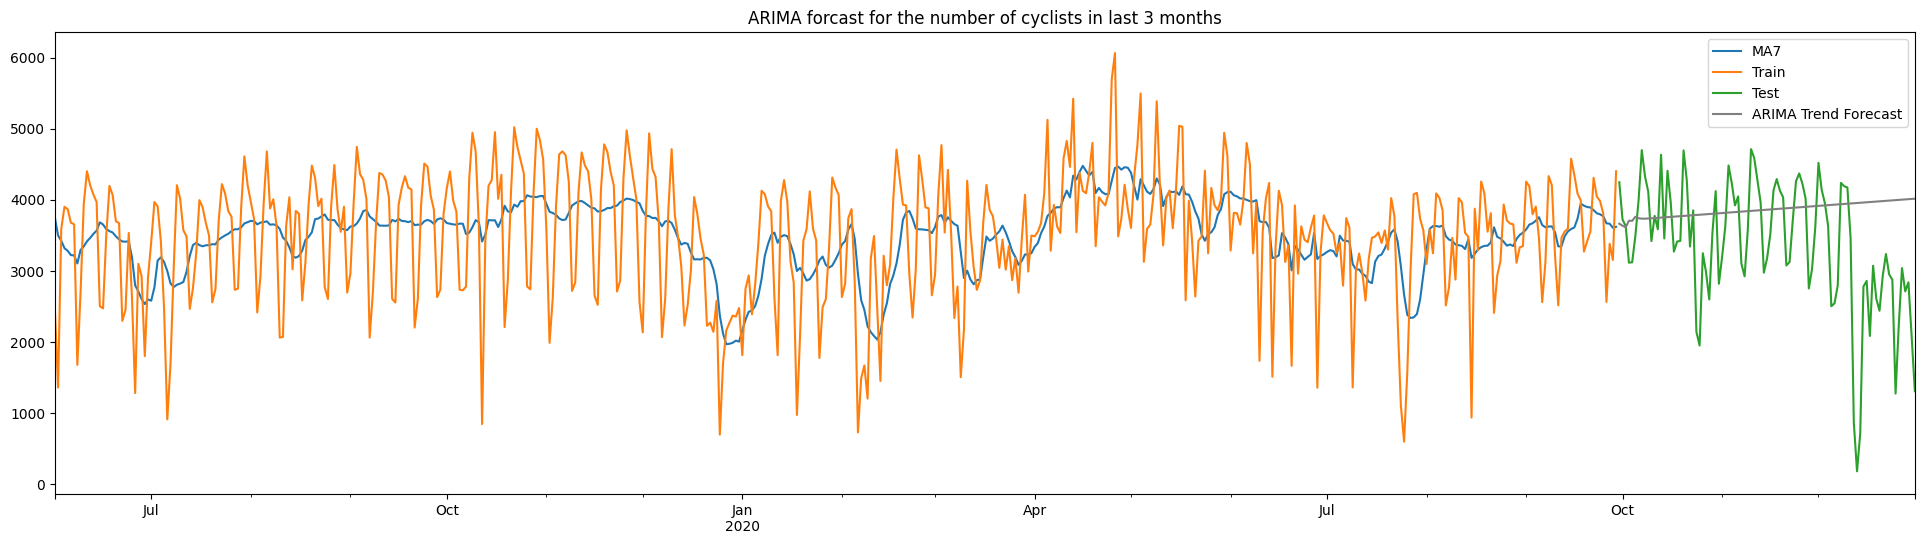

In [103]:
f_start= test_set.index[0]
f_end= test_set.index[-1]
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train_set_copy['MA7'].plot(label='MA7', ax=ax_arima_fcst)
train_set_copy['Value'].plot(label='Train', ax=ax_arima_fcst)
test_set['Value'].plot(label='Test', ax=ax_arima_fcst)
arima_predictions['Trend'].plot(color='grey', label='ARIMA Trend Forecast', ax=ax_arima_fcst)
ax_arima_fcst.set_xlim('2019-06', f_end)
plt.title("ARIMA forcast for the number of cyclists in last 3 months")
plt.legend()
plt.show()

Well, the trend prediction looks good, it seems like a straight line

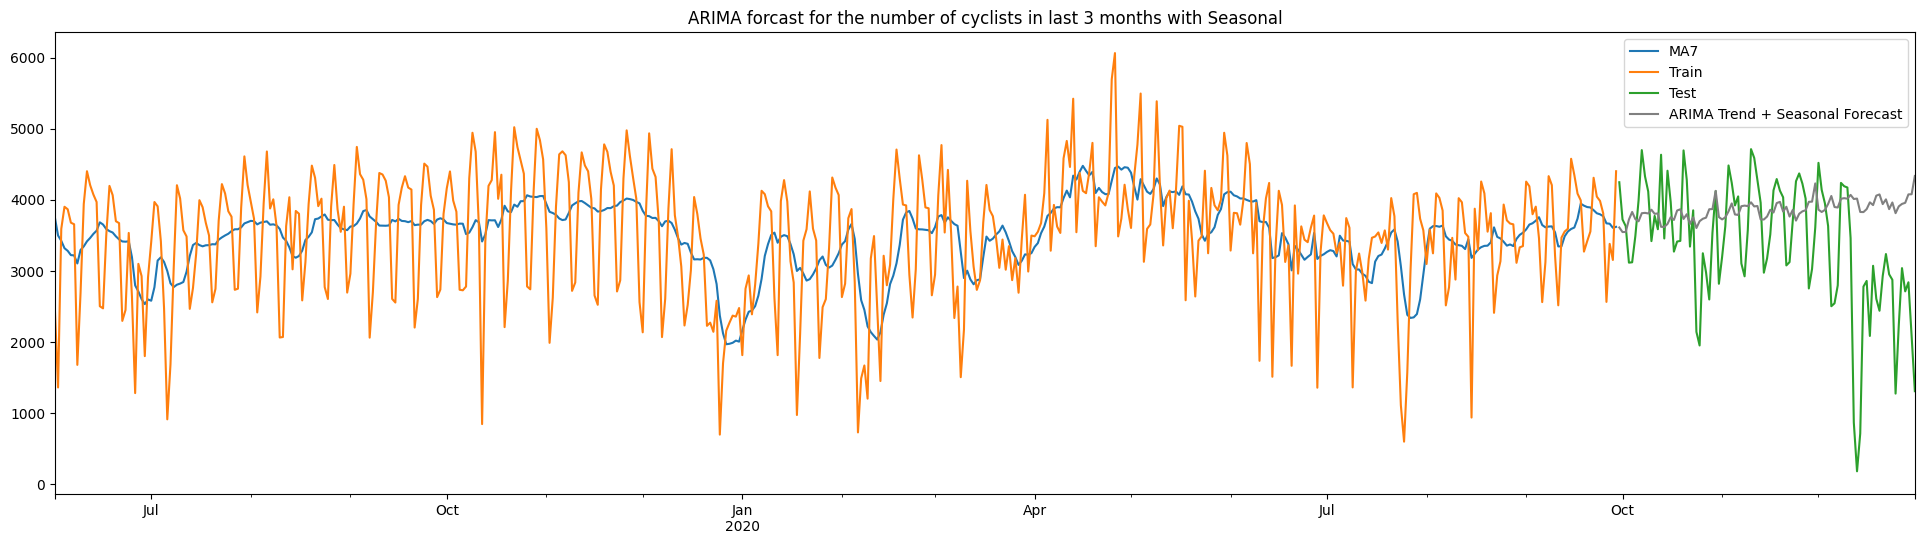

In [104]:
f_start= test_set.index[0]
f_end= test_set.index[-1]
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train_set_copy['MA7'].plot(label='MA7', ax=ax_arima_fcst)
train_set_copy['Value'].plot(label='Train', ax=ax_arima_fcst)
test_set['Value'].plot(label='Test', ax=ax_arima_fcst)
arima_predictions['TrendSeasonal'].plot(color='grey', label='ARIMA Trend + Seasonal Forecast', ax=ax_arima_fcst)
ax_arima_fcst.set_xlim('2019-06', f_end)
plt.title("ARIMA forcast for the number of cyclists in last 3 months with Seasonal")
plt.legend()
plt.show()

After adding the seasonal, we got a better result

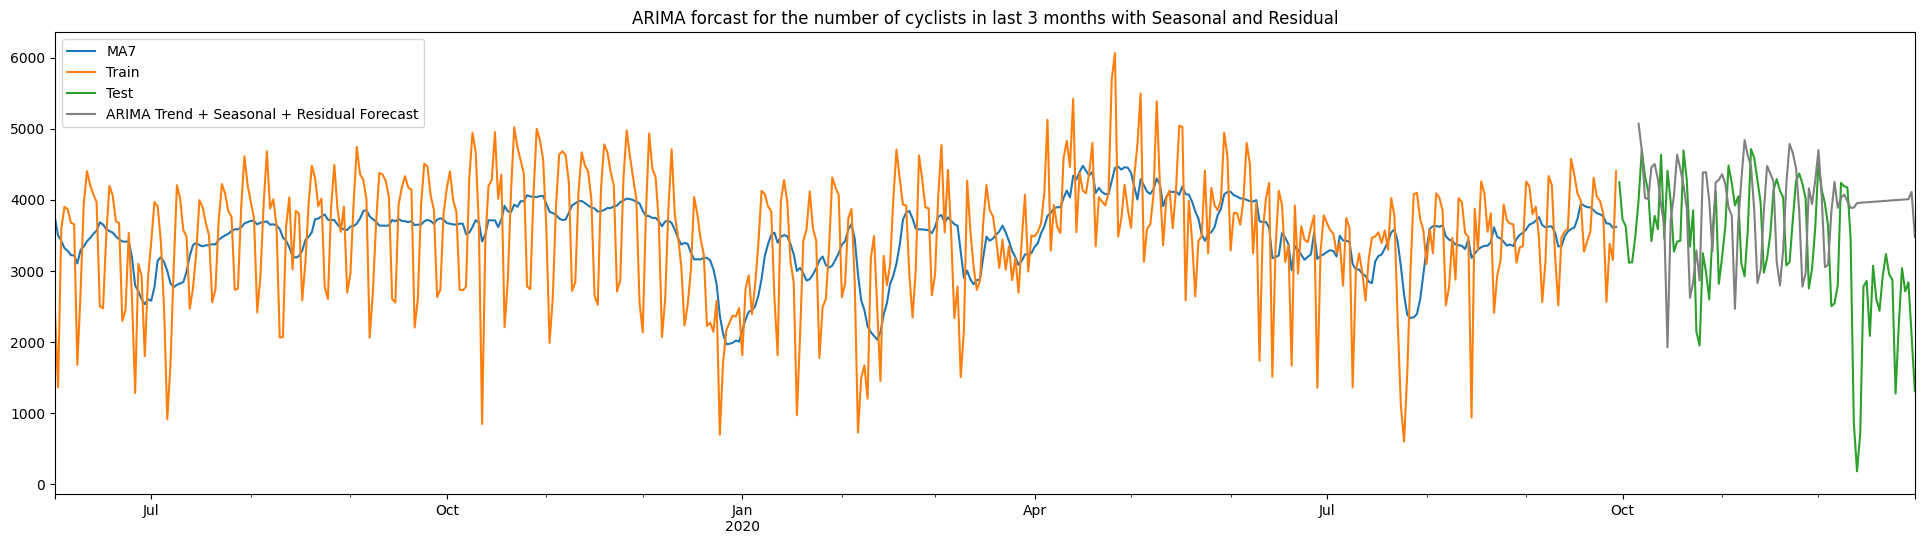

In [105]:
f_start= test_set.index[0]
f_end= test_set.index[-1]
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train_set_copy['MA7'].plot(label='MA7', ax=ax_arima_fcst)
train_set_copy['Value'].plot(label='Train', ax=ax_arima_fcst)
test_set['Value'].plot(label='Test', ax=ax_arima_fcst)
arima_predictions['Total'].plot(color='grey', label='ARIMA Trend + Seasonal + Residual Forecast', ax=ax_arima_fcst)
ax_arima_fcst.set_xlim('2019-06', f_end)
plt.title("ARIMA forcast for the number of cyclists in last 3 months with Seasonal and Residual")
plt.legend()
plt.show()

To compare with the original data from test set, adding residual is a good choice

In [106]:
len(test_set) / len(train_set_copy) + len(test_set)

93.05363321799308

## Using Auto-arima


In [107]:
print("Train length: ", len(train_set))
print("Test length: ",len(test_set))
print("Ratio: ", (len(test_set))/ (len(test_set)+len(train_set)))  

Train length:  1734
Test length:  93
Ratio:  0.05090311986863711


Here, the ratio between test and train sets is huge, which means we use much more data on training. This may lead to overfitting? Let's check

In [108]:
# # Calculate the start date of the train set 2
# train_start_date2 = test_start_date - pd.DateOffset(months=12)

# # Split the data into train and test sets 2
# train_set2 = time_series_df[(time_series_df.index >= train_start_date2) & (time_series_df.index < test_start_date)]
# test_set2 = time_series_df[(time_series_df.index >= test_start_date) & (time_series_df.index <= test_end_date)]

# print("Train set shape:", train_set2.shape)
# print("Test set shape:", test_set2.shape)
# print("Ratio: ", (len(test_set2))/ (len(test_set2)+len(train_set2)))  # 80% for train - 20% for test


In [109]:
# print("Start date for train: ", train_set2.index[0])
# print("Start date for test: ", test_set2.index[0])
# print("End date for test: ", test_set2.index[-1])

In [110]:
stepwise_model = auto_arima(train_set, start_p=6, start_q=6,
                            max_p=10, max_q=10, m=7, seasonal=True,
                            d=None, D=None, trace=True,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)
# here, I ignored the ratio of train and test sets. Well, I tried to split 80% - 20%, but I got bad results.
# a bad thing is that it's hard to tell wherther the model is overfitting or not, we have to do further evaluation to conclude.

# - train_set: trainning data
# - start_p and start_q: Initial values for AR and MA orders.
# - max_p and max_q: Maximum AR and MA orders to consider.
# - m: Seasonality of the time series (if seasonal is True). m = 7 is 7 days for seasonal
# - d and D: Orders of differencing.
# - trace=True: Prints model selection progress.
# - error_action='ignore': Ignores errors during model selection.
# - suppress_warnings=True: Suppresses warnings.
# - stepwise=True: Automatically selects the best model using stepwise search.

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,0,1)[7] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=28178.128, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=27731.866, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=27850.542, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=28176.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=28175.785, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=27541.464, Time=0.98 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=27309.771, Time=2.72 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=27281.951, Time=1.09 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=27922.322, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=27354.887, Time=2.51 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=27798.093, Time=0.88 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=27286.417, Time=2.86 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=27402.819, Time=0.87 sec
 ARIMA(2,1,0)(1,0,1)[7] i

In [111]:
stepwise_model.aic()


27198.86280262476

In [112]:
stepwise_model.fit(train_set)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True)

The algorithm chooses automactically the best model based on AIC, for seasonnal is 7 days

In [113]:
future_forcast = stepwise_model.predict(n_periods=len(test_set)) 
future_forcast

2020-09-30    4121.303947
2020-10-01    3693.176061
2020-10-02    3682.479878
2020-10-03    3250.299971
2020-10-04    3525.384944
                 ...     
2020-12-27    3606.959549
2020-12-28    3552.202708
2020-12-29    4321.178134
2020-12-30    4152.818080
2020-12-31    3796.681769
Freq: D, Length: 93, dtype: float64

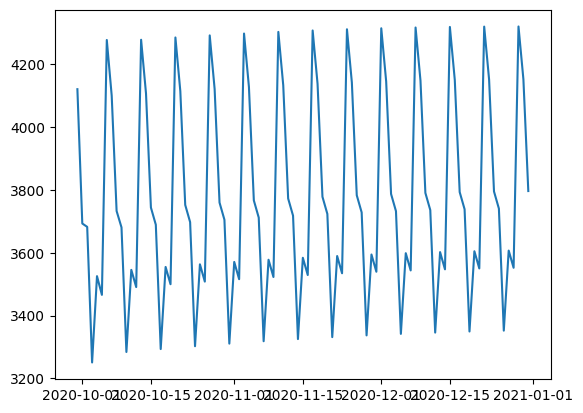

In [114]:
plt.plot(future_forcast)

In [115]:
future_forcast_df = pd.DataFrame(future_forcast, index= test_set.index, columns=['Prediction'])
future_forcast_df.head()
     

Prediction
2020-09-30  4121.303947
2020-10-01  3693.176061
2020-10-02  3682.479878
2020-10-03  3250.299971
2020-10-04  3525.384944

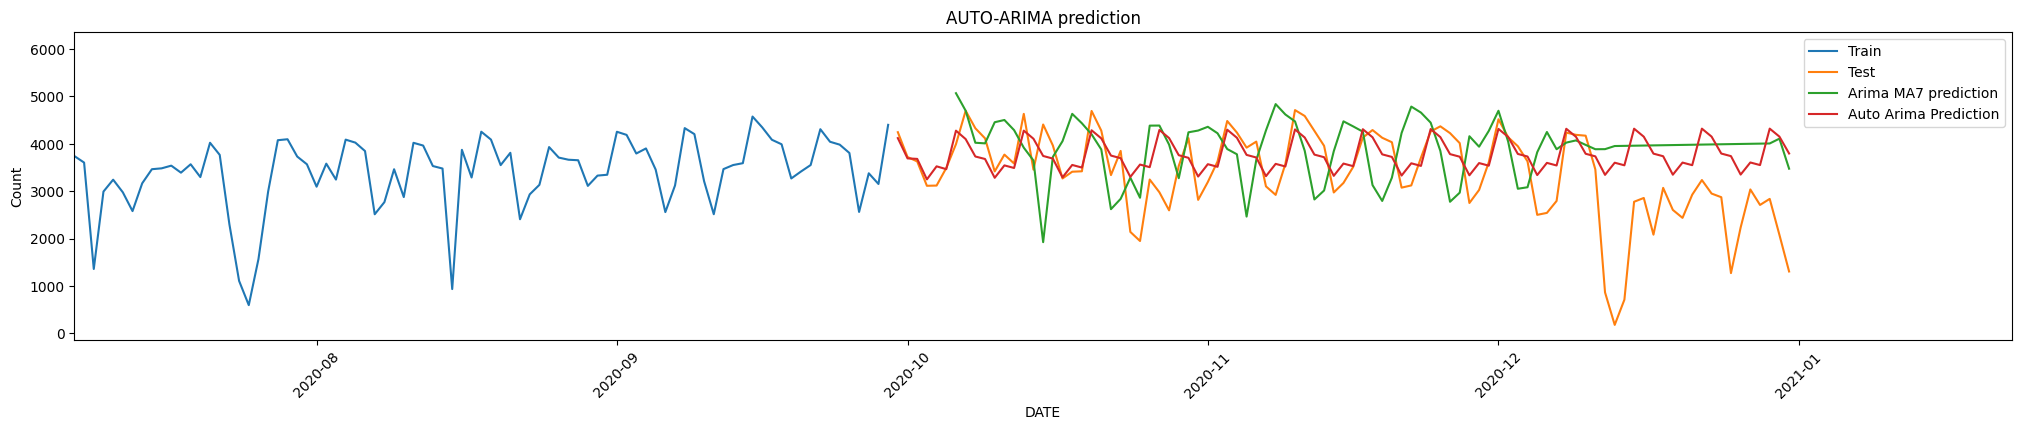

In [116]:
plt.figure(figsize=(25,4))
plt.title("AUTO-ARIMA prediction")
plt.plot(train_set, label="Train")
plt.plot(test_set, label="Test")
plt.plot(arima_predictions['Total'], label="Arima MA7 prediction")
plt.plot(future_forcast_df, label="Auto Arima Prediction")
plt.xlabel("DATE")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.xlim(18450, 18650)
plt.legend()
plt.show()
     

Seem good, however, I think this model can't do the long prediction, we can see that the curve are repeated seasonally.

# 5. Pure forcasters

In [117]:
#  For ease of acces, this data is arranged in four columns in the dataframe:
data_np = np.array(pd.concat([time_series_df[['Value']], 
                 time_series_df[['Value']].shift(), 
                 time_series_df[['Value']].shift(2),
                 time_series_df[['Value']].shift(3),
                 time_series_df[['Value']].shift(4)], 
                 axis=1
                 )
            )
print(data_np)


[[1785.   nan   nan   nan   nan]
 [2556. 1785.   nan   nan   nan]
 [2059. 2556. 1785.   nan   nan]
 ...
 [2839. 2711. 3038. 2236. 1273.]
 [2081. 2839. 2711. 3038. 2236.]
 [1307. 2081. 2839. 2711. 3038.]]


HERE, I trained the model directly with the original data instead of trainning the trend (MA7) then adding the seasonal from train_set_copy['Seasonal'] above. Well, we can do that as well, just change time_series_df[['Value']] to train_set_copy[['MA7']], but I think LSTM model is good enough to do the things above without splitting.

Shift() means we take the next _ values to be the "real" outputs of current trained value. Here, I take 4 next values.

In [118]:
# last 3 months for test
train2, test2 = data_np[4:-93], data_np[-93:]

In [119]:
# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train2)
test_scaled = scaler.transform(test2)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

Use the code below if you want to use cross-validation. The validation set is the last 3 months BEFORE the test set.

In [120]:
# # With validation
# validation_size = 93  # 3 months
# test_size = len(test2)

# train_data = train2[:-validation_size - test_size]
# validation_data = train2[-validation_size - test_size:-test_size]

# test_data = test2

# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_data)
# validation_scaled = scaler.transform(validation_data)
# test_scaled = scaler.transform(test_data)

# y_train = train_scaled[:, 0]
# X_train = train_scaled[:, 1:]

# y_validation = validation_scaled[:, 0]
# X_validation = validation_scaled[:, 1:]

# y_test = test_scaled[:, 0]
# X_test = test_scaled[:, 1:]


In [121]:
len(X_test) / (len(X_test) + len(X_train))

0.0510148107515085

In [122]:
def build_and_train_lstm(X_train, y_train, X_validation = None, y_validation = None, patience = 10, epochs=100, batch_size=16, learning_rate=0.001):
   # Create an LSTM model
   #input_dim = X_train.shape[1]
   model = keras.Sequential()
   model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
   model.add(keras.layers.LSTM(32))
   model.add(keras.layers.Dense(1))
   model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

   if (X_validation is not None or y_validation is not None):
      early_stopping = EarlyStopping(monitor='val_loss', patience= patience, restore_best_weights=True)
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                           validation_data=(X_validation, y_validation), callbacks=[early_stopping])
   else:
      early_stopping = EarlyStopping(monitor='loss', patience= patience, restore_best_weights=True) 
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
   
   return model, history

In [123]:
mylstm, history_lstm = build_and_train_lstm(X_train, y_train, X_test, y_test, patience=20, epochs=250)

Epoch 1/250
109/109 [==============================] - 4s 10ms/step - loss: 0.0447 - val_loss: 0.0192
Epoch 2/250
109/109 [==============================] - 0s 3ms/step - loss: 0.0196 - val_loss: 0.0186
Epoch 3/250
109/109 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 4/250
109/109 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 5/250
109/109 [==============================] - 0s 3ms/step - loss: 0.0182 - val_loss: 0.0193
Epoch 6/250
109/109 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 7/250
109/109 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 8/250
109/109 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0154
Epoch 9/250
109/109 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 10/250
109/109 [==============================] - 0s 3ms/step - loss: 0.0153 - val_l

# 6. Evalutation

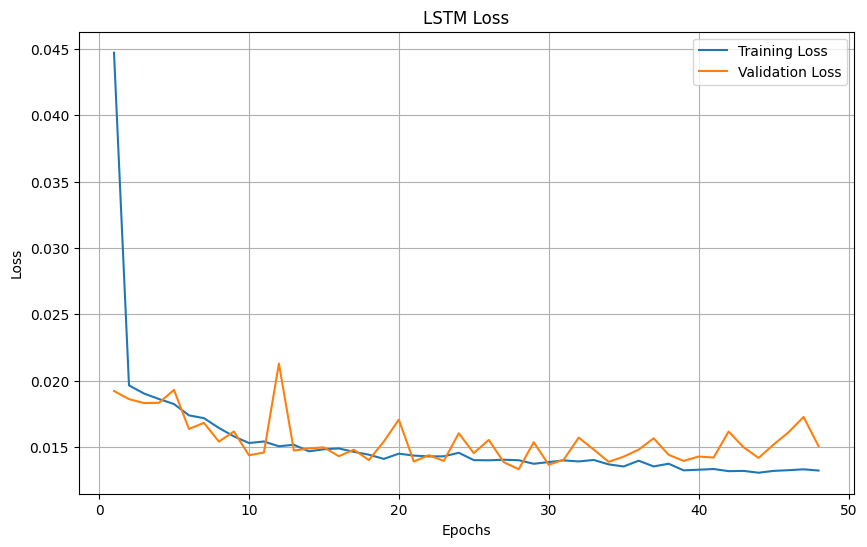

In [124]:
# Access the training history
lstm_loss = history_lstm.history['loss']
lstm_epochs = range(1, len(lstm_loss) + 1)

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(lstm_epochs, history_lstm.history['loss'], label='Training Loss')
plt.plot(lstm_epochs, history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

This shows that the model was trained good, there's no overfitting or underfitting due to the low validation loss and train loss together. I used Early Stopping the stop the training early if the model are getting worse in 20 times running.

EDIT: I realise that creating validation set for time-series model is more difficult than I thought. We should you some other techniques to do that, it's not simply splitting the time like what I did.

3/3 [==============================] - 2s 2ms/step


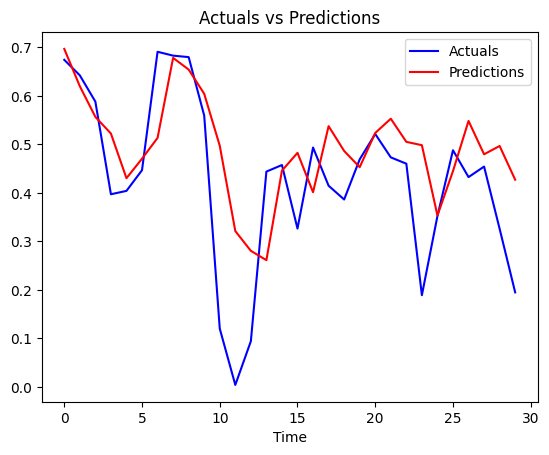

In [125]:
def plot_pred(y_test,y_pred,period=30):
    plt.figure()
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test, mylstm.predict(X_test))

3/3 [==============================] - 0s 3ms/step


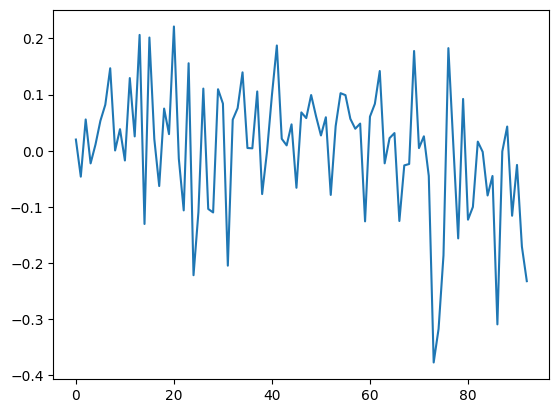

In [126]:
errors = np.squeeze(y_test) - np.squeeze(mylstm.predict(X_test))
plt.plot(errors)

In [127]:
def plot_lstm_predictions_with_date(train, test, predictions, title):
    date_range = pd.date_range(start="2016-01-01", periods=len(train) + len(test), freq='D')

    plt.figure(figsize=(12, 6))
    plt.plot(date_range[:len(train)], train, label='Training Data', color='blue')
    plt.plot(date_range[len(train):], test, label='Test Data', color='green')
    plt.plot(date_range[len(train):], predictions, label='Predictions', linestyle='dashed', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.title(title)
    plt.grid(True)

    start_date = pd.to_datetime("2020-01-01")
    end_date = date_range[-1]
    plt.xlim(start_date, end_date)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.xticks(rotation=45)
    plt.show()


3/3 [==============================] - 0s 4ms/step


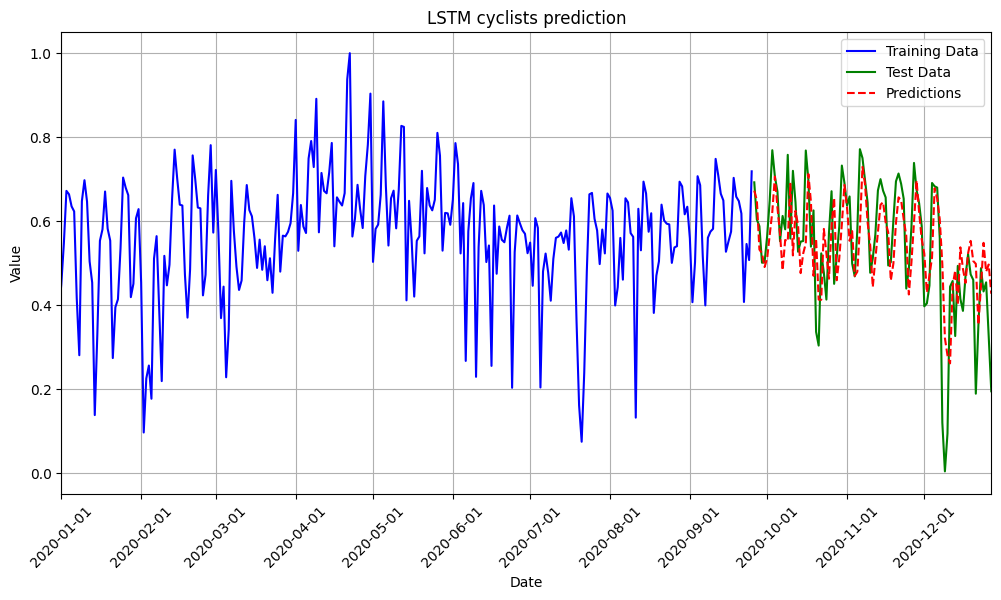

In [128]:
plot_lstm_predictions_with_date(y_train, y_test, mylstm.predict(X_test), title="LSTM cyclists prediction")

The model looks good. However, for the long-term prediction, it's hard to say the LSTM model can work perfectly, I think we should retrain the model periodly to keep the trend to be up-to-date.

In [129]:
# Inverse transform the scaled predictions and true values
y_pred_lstm_unscaled = scaler.inverse_transform(np.hstack((mylstm.predict(X_test), X_test)))
y_true_unscaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test)))

# Calculate the MSE
mse_lstm = mean_squared_error(y_true_unscaled[:, 0], y_pred_lstm_unscaled[:, 0])

print("Mean Squared Error LSTM:", mse_lstm)

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step
Mean Squared Error LSTM: 465200.0625175135


Because the first 6 rows were used to calculate the moving average (MA7), these rows contain null values. I cut off these rows before doing the comparison

In [130]:
# MA7 => first 6 rows are null values
div = 6

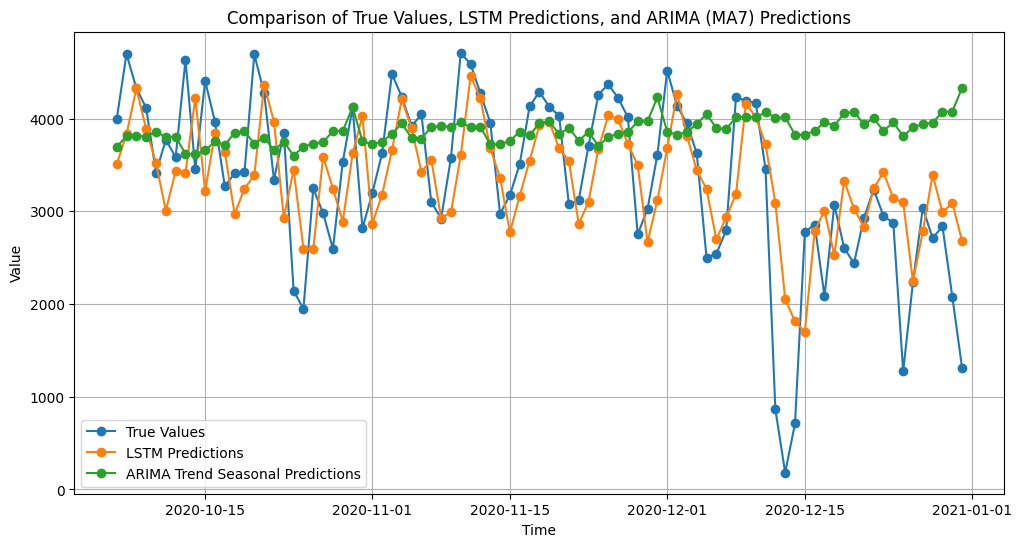

In [131]:
# Create a figure and plot the data
plt.figure(figsize=(12, 6))
plt.plot(test_set.index[div:], y_true_unscaled[div:, 0], label='True Values', marker='o', linestyle='-')
plt.plot(test_set.index[div:], y_pred_lstm_unscaled[div:, 0], label='LSTM Predictions', marker='o', linestyle='-')
#plt.plot(test_set.index[div:], arima_predictions[div:]['Total'], label='ARIMA (MA7) Predictions', marker='o', linestyle='-')
plt.plot(test_set.index[div:], arima_predictions[div:]['TrendSeasonal'], label='ARIMA Trend Seasonal Predictions', marker='o', linestyle='-')

plt.title('Comparison of True Values, LSTM Predictions, and ARIMA (MA7) Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()

In [132]:
mean_squared_error(y_true_unscaled[div:, 0], arima_predictions[div:]['Total'])

1579064.0555192356

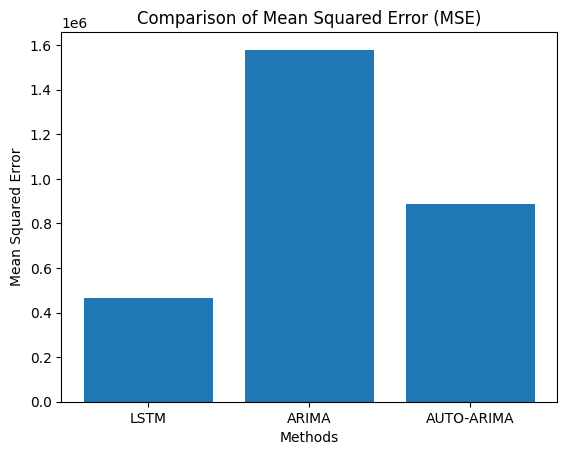

In [133]:
mse_lstm = mean_squared_error(y_true_unscaled[:, 0], y_pred_lstm_unscaled[:, 0])
mse_arima = mean_squared_error(y_true_unscaled[div:, 0], arima_predictions[div:]['Total'])
mse_auto_arima = mean_squared_error(y_true_unscaled[div:, 0], future_forcast_df[div:]['Prediction'])

methods = ['LSTM', 'ARIMA', 'AUTO-ARIMA']
mse_values = [mse_lstm, mse_arima, mse_auto_arima]

plt.bar(methods, mse_values)
plt.xlabel('Methods')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Error (MSE)')

plt.show()

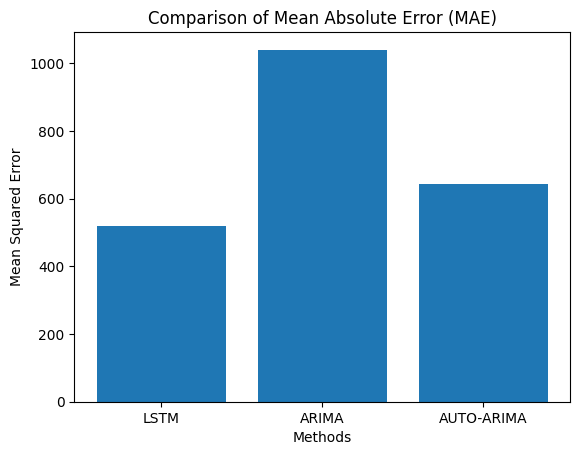

In [134]:
mae_lstm = mean_absolute_error(y_true_unscaled[:, 0], y_pred_lstm_unscaled[:, 0])
mae_arima = mean_absolute_error(y_true_unscaled[div:, 0], arima_predictions[div:]['Total'])
mae_auto_arima = mean_absolute_error(y_true_unscaled[div:, 0], future_forcast_df[div:]['Prediction'])

# Create a bar plot
methods = ['LSTM', 'ARIMA', 'AUTO-ARIMA']
mae_values = [mae_lstm, mae_arima, mae_auto_arima]

plt.bar(methods, mae_values)
plt.xlabel('Methods')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Absolute Error (MAE)')

plt.show()

From MAEs and MSEs above, we can see that LSTM model is better than Arima models.